In [1]:
import numpy as np
import matplotlib.pyplot as plt

arm_mass = 0.2 #kg
arm_length = 0.6 #meter
motor_mass = 0.065

arm_lengths = [arm_length,]*4

total_inertia_tensor = np.zeros((3, 3))

arms_inertia_tensor = np.zeros((3, 3))
arms_inertia_tensor[0, 0] = 2*(1/12)*arm_mass*arm_length**2
arms_inertia_tensor[1, 1] = (1/12)*arm_mass*arm_length**2
arms_inertia_tensor[2, 2] = (1/12)*arm_mass*arm_length**2

motors_inertia_tensor = np.zeros((3, 3))
motors_inertia_tensor[0, 0] = 2*motor_mass*arm_length**2
motors_inertia_tensor[1, 1] = 2*motor_mass*arm_length**2
motors_inertia_tensor[2, 2] = 4*motor_mass*arm_length**2

total_inertia_tensor = arms_inertia_tensor + motors_inertia_tensor

In [2]:
def get_dyn_constants(body_mass):
    prop_radius = 0.1016 # meters
    prop_pitch = 0.1143 # meters
    c_d = 0.09 # airfoil
    body_max_omega_z = 100*(np.pi/180) # radians/second; max body angular velocity about z axis
    
    neutral_buoyancy_pulse = 750 # unitless
    g = 9.81
    k_force = body_mass*g/(4*((neutral_buoyancy_pulse)**2))
    k_torque = 0.5*(prop_radius**4)*prop_pitch*c_d*(body_max_omega_z**2)
    return k_force, k_torque


In [3]:
def get_body_constants():
    
    arm_mass = 0.2 #kg
    arm_length = 0.6 #meter
    motor_mass = 0.065

    arm_lengths = [arm_length,]*4

    total_inertia_tensor = np.zeros((3, 3))

    arms_inertia_tensor = np.zeros((3, 3))
    arms_inertia_tensor[0, 0] = (1/12)*arm_mass*arm_length**2
    arms_inertia_tensor[1, 1] = (1/12)*arm_mass*arm_length**2
    arms_inertia_tensor[2, 2] = (1/12)*arm_mass*arm_length**2

    motors_inertia_tensor = np.zeros((3, 3))
    motors_inertia_tensor[0, 0] = 2*motor_mass*arm_length**2
    motors_inertia_tensor[1, 1] = 2*motor_mass*arm_length**2
    motors_inertia_tensor[2, 2] = 4*motor_mass*arm_length**2

    total_inertia_tensor = arms_inertia_tensor + motors_inertia_tensor

    body_mass = arm_mass*2 + motor_mass*4
    return body_mass, total_inertia_tensor, arm_lengths

In [4]:
def tait_bryan_from_quat(q_cur):
    phi   = np.arctan2(2*(q_cur[0]*q_cur[1] + q_cur[2]*q_cur[3]), 1. - 2.*(q_cur[1]**2 + q_cur[2]**2))*180/np.pi
    theta = np.arcsin(2*(q_cur[0]*q_cur[2] - q_cur[3]*q_cur[1]))*180/np.pi
    psi   = np.arctan2(2*(q_cur[0]*q_cur[3] + q_cur[1]*q_cur[2]), 1. - 2.*(q_cur[2]**2 + q_cur[3]**2))*180/np.pi
    return phi, theta, psi #returns degrees

In [5]:
def quat_mult(q1, q2):
    #print(q1, q2)
    #print(q1.shape, q2.shape)
    #q3 = np.zeros((1, 4))
    q3 = np.array([0., 0., 0., 0.,])
    q3[0] = q1[0]*q2[0] - q1[1:].dot(q2[1:])
    q3[1:] = q1[0]*q2[1:] + q2[0]*q1[1:] + np.cross(q1[1:], q2[1:])
    return q3

In [6]:
def quat_inv(q1):
    #q2 = np.zeros((1, 4))
    q2 = np.array([0., 0., 0., 0.,])
    mag = np.linalg.norm(q1)
    q2[0] = q1[0]
    q2[1:] = -1.*q1[1:]
    q2 /= (mag*mag)
    return q2

In [7]:
def calc_omega_dot_body(omega_body, inertia_body, torques_body):
    cp = np.cross(omega_body, inertia_body.dot(omega_body))
    inv_inert = np.linalg.inv(inertia_body)
    #print("inv inertia:\n", inv_inert)
    #print("omega_dot_body cross product:", cp)
    omega_dot_body = inv_inert.dot(torques_body - cp)
    return omega_dot_body

In [8]:
# Expects motor_speeds to be a 4-length array with values of (pulse_width_i - 1000)
def get_torques_body(motor_speeds, arm_lengths, k_force, k_torque):
    #torques_body = np.zeros((1, 3))
    torques_body = np.array([0., 0., 0.,])
    #print("torques_body:", torques_body)
    torques_body[0] = arm_lengths[1]*k_force*(motor_speeds[1]**2) - arm_lengths[3]*k_force*(motor_speeds[3]**2)
    torques_body[1] = arm_lengths[2]*k_force*(motor_speeds[2]**2) - arm_lengths[0]*k_force*(motor_speeds[0]**2)
    #torques_body[0] = arm_lengths[3]*k_force*(motor_speeds[3]**2) + arm_lengths[2]*k_force*(motor_speeds[2]**2) - arm_lengths[0]*k_force*(motor_speeds[0]**2) - arm_lengths[1]*k_force*(motor_speeds[1]**2)
    #torques_body[1] = arm_lengths[3]*k_force*(motor_speeds[3]**2) - arm_lengths[2]*k_force*(motor_speeds[2]**2) + arm_lengths[0]*k_force*(motor_speeds[0]**2) - arm_lengths[1]*k_force*(motor_speeds[1]**2)
    torques_body[2] = k_torque*(-1*motor_speeds[0]**2 + motor_speeds[1]**2 - motor_speeds[2]**2 + motor_speeds[3]**2)
    #print("torques_body after stuff:", torques_body)
    return torques_body

In [9]:
# Expects motor_speeds to be a 4-length array with values of (pulse_width_i - 1000)
def get_forces_body(motor_speeds, k_force):
    #forces_body = np.zeros((1, 3))
    forces_body = np.array([0., 0., 0.,])
    forces_body[2] = k_force*sum([s**2 for s in motor_speeds])
    return forces_body

In [10]:
# Expects motor_speeds to be a 4-length array with values of (pulse_width_i - 1000)
def update_orientation_body(
    omega_body_prev,
    q_body_prev,
    dt,
    arm_lengths,
    k_force,
    k_torque,
    inertia_body,
    motor_speeds
):
    torques_body = get_torques_body(motor_speeds, arm_lengths, k_force, k_torque)
    #print("torques:", torques_body)
    omega_dot_body = calc_omega_dot_body(omega_body_prev, inertia_body, torques_body)
    #print("omega_dot_body", omega_dot_body)
    omega_body = omega_body_prev + omega_dot_body*dt
    #print("omega_body_prev:", omega_body_prev)
    
    theta = -np.pi/2 - np.pi/4
    R_z = np.zeros((3, 3))
    R_z[0, 0] = np.cos(theta)
    R_z[0, 1] = -np.sin(theta)
    R_z[1, 0] = np.sin(theta)
    R_z[1, 1] = np.cos(theta)
    R_z[2, 2] = 1.
    omega_body_rot = R_z.dot(omega_body)
    #print("omega_body_rot:", omega_body_rot)
    delta_theta_dot = np.linalg.norm(omega_body_rot)
    quat_omega_body = np.array([np.cos(delta_theta_dot*dt/2.)] + list(np.sin(delta_theta_dot*dt/2.)*omega_body_rot/(delta_theta_dot + 1e-8)))
    q_body = quat_mult(q_body_prev, quat_omega_body)
    if np.linalg.norm(q_body) < 0.999:
        q_body += 0.1*(1. - np.linalg.norm(q_body)**2)*q_body
    #print("q_body update_orientation_body:", q_body)
    return q_body, omega_body

In [11]:
# Expects motor_speeds to be a 4-length array with values of (pulse_width_i - 1000)
def get_force_inertial(vel_inert_prev, q_body, motor_speeds, k_force, k_damp, body_mass):

    forces_body = get_forces_body(motor_speeds, k_force)
    #print("forces_body:", forces_body)
    forces_body_quat = np.array([0., 0., 0., 0.,])
    forces_body_quat[1:] = forces_body
    net_force_inert = body_mass*np.array([0, 0, -9.8]) + \
        quat_mult(quat_mult(quat_inv(q_body), forces_body_quat), q_body)[1:] - \
        k_damp*vel_inert_prev
    return net_force_inert

In [12]:
# Expects motor_speeds to be a 4-length array with values of (pulse_width_i - 1000)
def update_pos_vel_inertial(
    pos_inert_prev,
    vel_inert_prev,
    accel_inert_prev,
    q_body,
    motor_speeds,
    k_force,
    k_damp,
    body_mass,
    dt
):
    
    # Velocity verlet
    pos_inert = pos_inert_prev + vel_inert_prev*dt + 0.5*accel_inert_prev*dt*dt
    accel_inert = get_force_inertial(vel_inert_prev, q_body, motor_speeds, k_force, k_damp, body_mass)/body_mass
    #print("accel_inert:", accel_inert)
    vel_inert = vel_inert_prev + 0.5*(accel_inert + accel_inert_prev)*dt
    
    return pos_inert, vel_inert, accel_inert

In [13]:
class PID(object):
    def __init__(self, kp, ki, kd, out_max=np.inf, out_min=-np.inf):
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.out_max = out_max
        self.out_min = out_min
        self.error_prev = 0.
        self.error_integ = 0.
        self.updated = False
        
    def update(self, sig_in, sig_set):
        #error = sig_in - sig_set
        error = sig_set - sig_in
        if not self.updated:
            sig_out = self.kp*error
            self.error_prev = error
            self.error_integ += error
            self.updated = True
            return sig_out
        
        error_dot = error - self.error_prev
        self.integrate(error)
        sig_out = self.kp*error + self.kd*error_dot + self.ki*self.error_integ
        sig_out_bounded = self.bound(sig_out)
        self.error_prev = error
        #print("sig out bounded:", sig_out_bounded, "sig out:", sig_out)
        return sig_out_bounded
        
    def bound(self, sig_out):
        #print("sig_out < out_max:", sig_out < self.out_max)
        #print("sig_out > out_min:", sig_out > self.out_min)
        #print("min, sig_out, max:", self.out_min, self.out_max, sig_out)
        return max(
            min(sig_out, self.out_max),
            self.out_min
        )
    
    def integrate(self, error):
        if self.error_integ <= self.out_max and self.error_integ >= self.out_min:
            self.error_integ += error
            
        return self.error_integ

class AttitudeController(object):
    # Cascaded PID controller
    # theta_cur ___     _____
    #              |___|     |
    #               ___| PID |____
    # theta_set ___|   |_____|    |                    _____
    #                             |__theta_dot_set____|     |
    #                                             ____| PID |___motor_pulse___
    # theta_dot_cur______________________________|    |_____|
    
    def __init__(self, angle_gains, omega_gains, omega_bounds, psi_gains, psi_bounds):
        self.pid_phi        = PID(angle_gains[0], angle_gains[1], angle_gains[2])
        self.pid_theta      = PID(angle_gains[0], angle_gains[1], angle_gains[2])
        self.pid_phi_dot    = PID(omega_gains[0], omega_gains[1], omega_gains[2], max(omega_bounds), min(omega_bounds))
        self.pid_theta_dot  = PID(omega_gains[0], omega_gains[1], omega_gains[2], max(omega_bounds), min(omega_bounds))
        self.pid_psi_dot    = PID(psi_gains[0], psi_gains[1], psi_gains[2], max(psi_bounds), min(psi_bounds))
    
    def update(self, q_cur, omega_cur, setpoints):
        # omega_cur = [rad/s, rad/s, rad/s]
        # angle_setpoints = [deg_roll, deg_pitch, deg_yaw/s]

        phi   = np.arctan2(2*(q_cur[0]*q_cur[1] + q_cur[2]*q_cur[3]), 1. - 2.*(q_cur[1]**2 + q_cur[2]**2))*180/np.pi
        theta = np.arcsin(2*(q_cur[0]*q_cur[2] - q_cur[3]*q_cur[1]))*180/np.pi

        #print("controller update phi:", phi, "\t theta:", theta, "\t q_cur magnitude:", np.linalg.norm(q_cur))
        
        phi_dot   = omega_cur[0]*180/np.pi
        theta_dot = omega_cur[1]*180/np.pi
        psi_dot   = omega_cur[2]*180/np.pi
        
        omega_setpoint = [None, None, None]
        omega_setpoint[0] = self.pid_phi.update(phi, setpoints[0])
        omega_setpoint[1] = self.pid_theta.update(theta, setpoints[1])
        omega_setpoint[2] = self.pid_psi_dot.update(psi_dot, setpoints[2])
        
        #print("roll_dot_setpoint:", omega_setpoint[0])
        
        roll_command  = self.pid_phi_dot.update(phi_dot, omega_setpoint[0])
        pitch_command = self.pid_theta_dot.update(theta_dot, omega_setpoint[1])
        yaw_dot_command = omega_setpoint[2]
        
        return roll_command, pitch_command, yaw_dot_command
    
    # Callable function returns motor pulses
    def __call__(self, q_cur, omega_cur, setpoints, throttle):
        roll_comm, pitch_comm, yaw_dot_comm = self.update(q_cur, omega_cur, setpoints)
        #print("roll command:", roll_comm, "\t pitch command:", pitch_comm, "\t yaw dot command:", yaw_dot_comm)
        # which motors are on the left and which are on the right? goddamnit.
        # Right side: M1, M2
        # Left side: M3, M4
        '''
                   Front
            CW   M3     M2  CCW
                   \   /
                    \_/
            Left    |_|   Right
                    / \
                   /   \
            CCW  M4     M1  CW
                   Back
        '''
        
        motor_pulses = [0,]*4
        motor_pulses[0] = throttle + roll_comm - pitch_comm - yaw_dot_comm
        motor_pulses[1] = throttle + roll_comm + pitch_comm + yaw_dot_comm
        motor_pulses[2] = throttle - roll_comm + pitch_comm - yaw_dot_comm
        motor_pulses[3] = throttle - roll_comm - pitch_comm + yaw_dot_comm
        return motor_pulses

In [14]:
def run_6dof(
    num_timesteps, # number of dt's
    dt,
    pos_init,
    vel_init,
    q_init,
    omega_init,
    controller=(lambda *x: np.array([750,]*4))
):
    body_mass, body_inertia_tensor, arm_lengths = get_body_constants()
    print("body inertia tensor:\n\n", body_inertia_tensor)
    k_force, k_torque = get_dyn_constants(body_mass)
    print("k_force:", k_force)
    print("body_mass:", body_mass)
    print("4*k_force*ms**2:", 4*k_force*(750**2))
    k_damp = 0.1 #swag
    omega_prev = omega_init
    pos_prev = pos_init
    vel_prev = vel_init
    accel_prev = np.array([0., 0., 0.])/body_mass
    q_prev = q_init
    
    first_run = True
    
    pos_cur = None
    vel_cur = None
    accel_cur = None
    q_cur = None
    omega_cur = None
    
    positions = []
    qs = []
    motor_speeds = [750,]*4
    times = []
    
    for t in range(0, num_timesteps):
        #print("###############################################")
        if first_run:
            motor_speeds = [750,]*4
            first_run = False
        else:
            motor_speeds = controller(q_prev, omega_prev, [0., 0., 0.], 750)
        #print("motor speeds:", motor_speeds)
        q_cur, omega_cur = update_orientation_body(
            omega_prev,
            q_prev,
            dt,
            arm_lengths,
            k_force,
            k_torque,
            body_inertia_tensor,
            motor_speeds
        )
        
        pos_cur, vel_cur, accel_cur = update_pos_vel_inertial(
            pos_prev,
            vel_prev,
            accel_prev,
            q_cur,
            motor_speeds,
            k_force,
            k_damp,
            body_mass,
            dt
        )
        pos_prev = pos_cur
        vel_prev = vel_cur
        accel_prev = accel_cur
        q_prev = q_cur
        omega_prev = omega_cur
        positions.append(pos_prev)
        qs.append(q_prev)
        
        if len(times) == 0:
            times.append(0.)
        else:
            times.append(times[-1] + dt)
        
        if np.any(np.isnan(q_cur)):
            print("Found nan in orientation quaternion, exiting")
            break
        
        if pos_cur[2] <= 0.:
            print("CM ended up below the floor, exiting")
            break
        
    return positions, qs, times

In [15]:
n = np.array([1., 1., 0])
n_hat = n/np.linalg.norm(n)
dtheta = 0*np.pi/3

q_init = np.array(
    [
        np.cos(dtheta/2),
        np.sin(dtheta/2)*n_hat[0],
        np.sin(dtheta/2)*n_hat[1],
        np.sin(dtheta/2)*n_hat[2],
    ]
)
omega_init = np.array([0, np.pi/4, 0])
pos_init = np.array([0, 0, 10])
vel_init = np.array([0, 0, -0.1])
g = 9.8 # meters/(second*second)

# Something weird is going on with the controller class, q_0 is wobbling
# around everywhere.
controller = AttitudeController([-10.0, 0.0, 10.], [2.0, 0.0, 10.], [-400, 400], [2.0, 0., 0.], [-400, 400])

positions, qs, times = run_6dof(10000, 0.0005, pos_init, vel_init, q_init, omega_init, controller)

body inertia tensor:

 [[0.0528 0.     0.    ]
 [0.     0.0528 0.    ]
 [0.     0.     0.0996]]
k_force: 2.8776e-06
body_mass: 0.66
4*k_force*ms**2: 6.474600000000001
###############################################
motor speeds: [750, 750, 750, 750]
torques: [0. 0. 0.]
omega_dot_body cross product: [0. 0. 0.]
omega_dot_body [0. 0. 0.]
omega_body_prev: [0.         0.78539816 0.        ]
omega_body_rot: [ 0.55536037 -0.55536037  0.        ]
###############################################
roll_dot_setpoint: 0.15909902783043955
motor speeds: [840.6363960990542, 660.0000000122676, 659.3636039009458, 839.9999999877324]
torques: [-4.66171200e-01 -4.69467528e-01 -3.83840754e-04]
omega_dot_body cross product: [0. 0. 0.]
omega_dot_body [-8.82900000e+00 -8.89143046e+00 -3.85382283e-03]
omega_body_prev: [0.         0.78539816 0.        ]
omega_body_rot: [ 5.55338295e-01 -5.49095249e-01 -1.92691142e-06]
###############################################
roll_dot_setpoint: 0.15909902783043958
motor spe

omega_body_prev: [-0.17619683  0.17297288 -0.01277491]
omega_body_rot: [ 0.24331615  0.00465857 -0.01282068]
###############################################
roll_dot_setpoint: 15.721561529928108
motor speeds: [834.2231299875384, 769.2882748241154, 662.8385871175076, 733.6500080708386]
torques: [ 0.09247821 -0.44298909 -0.00874227]
omega_dot_body cross product: [-0.00010126 -0.00010521  0.        ]
omega_dot_body [ 1.75339889 -8.38795231 -0.08777383]
omega_body_prev: [-0.1753446   0.16875639 -0.01282068]
omega_body_rot: [ 0.23973064  0.00700424 -0.01286456]
###############################################
roll_dot_setpoint: 15.791320460520406
motor speeds: [833.7554810185982, 769.7854541999584, 663.2961779469642, 733.1628868344792]
torques: [ 0.09503302 -0.4405946  -0.0083685 ]
omega_dot_body cross product: [-9.90767153e-05 -1.05040430e-04  0.00000000e+00]
omega_dot_body [ 1.80174419 -8.3426053  -0.0840211 ]
omega_body_prev: [-0.1744679   0.16456242 -0.01286456]
omega_body_rot: [ 0.23614

omega_body_rot: [-0.11600695  0.09392921 -0.00916215]
###############################################
roll_dot_setpoint: 17.42920711874383
motor speeds: [774.5658210054055, 788.792483128304, 723.3343695694814, 713.3073262968092]
torques: [ 0.19576815 -0.13249553  0.01308243]
omega_dot_body cross product: [6.36524841e-05 6.69395585e-06 0.00000000e+00]
omega_dot_body [ 3.7065245  -2.50951173  0.13134969]
omega_body_prev: [ 0.01561132 -0.14844728 -0.00916215]
omega_body_rot: [-0.11820465  0.093506   -0.00909647]
###############################################
roll_dot_setpoint: 17.3959923685666
motor speeds: [774.1074684270799, 788.6859356393871, 723.8077737134396, 713.3988222200934]
torques: [ 0.19525257 -0.13008711  0.01306109]
omega_dot_body cross product: [6.37303873e-05 7.43493450e-06 2.71050543e-20]
omega_dot_body [ 3.69675834 -2.46391183  0.13113541]
omega_body_prev: [ 0.01746459 -0.14970204 -0.00909647]
omega_body_rot: [-0.12038278  0.09307012 -0.0090309 ]
########################

roll_dot_setpoint: 10.725012753684139
motor speeds: [739.2621175023567, 762.7743064553924, 759.8620537210129, 738.101522321238]
torques: [0.06393587 0.05331939 0.00454053]
omega_dot_body cross product: [3.12213594e-05 3.02498101e-05 0.00000000e+00]
omega_dot_body [1.21031537 1.00926398 0.04558762]
omega_body_prev: [ 0.16913762 -0.1745699  -0.00382152]
omega_body_rot: [-0.243109    0.00305646 -0.00379873]
###############################################
roll_dot_setpoint: 10.655395407361482
motor speeds: [739.125158695369, 762.5084375987601, 760.0042364842764, 738.3621672215945]
torques: [0.06257127 0.05404209 0.00448324]
omega_dot_body cross product: [ 3.09454231e-05  3.01769677e-05 -2.16840434e-19]
omega_dot_body [1.18447589 1.02295283 0.04501246]
omega_body_prev: [ 0.16974278 -0.17406527 -0.00379873]
omega_body_rot: [-0.24316611  0.00227602 -0.00377622]
###############################################
roll_dot_setpoint: 10.58575767920471
motor speeds: [738.9907868621177, 762.2429248740

###############################################
roll_dot_setpoint: 2.742958312598789
motor speeds: [737.7844759609552, 737.0143946940377, 761.7549669795371, 763.44616236547]
torques: [-0.06847507  0.06206068  0.00241026]
omega_dot_body cross product: [8.58173140e-06 1.47321023e-05 0.00000000e+00]
omega_dot_body [-1.29703881  1.17511257  0.02419944]
omega_body_prev: [ 0.15664555 -0.09124903 -0.00200956]
omega_body_rot: [-0.1744139  -0.04619921 -0.00199746]
###############################################
roll_dot_setpoint: 2.6927479354881845
motor speeds: [737.8571804725998, 736.9008670394144, 761.6850355197723, 763.5569169682135]
torques: [-0.06905597  0.0616915   0.00241201]
omega_dot_body cross product: [8.47513468e-06 1.45827748e-05 0.00000000e+00]
omega_dot_body [-1.30803879  1.16812341  0.02421693]
omega_body_prev: [ 0.15599703 -0.09066147 -0.00199746]
omega_body_rot: [-0.17353844 -0.04614975 -0.00198535]
###############################################
roll_dot_setpoint: 2.64278792

omega_dot_body cross product: [1.71740793e-06 2.23472697e-06 0.00000000e+00]
omega_dot_body [-1.67428439  0.28040292  0.0179289 ]
omega_body_prev: [ 0.06520059 -0.05010725 -0.00073236]
omega_body_rot: [-0.08084387 -0.0101798  -0.0007234 ]
###############################################
roll_dot_setpoint: -1.391110095966889
motor speeds: [747.127177622957, 733.0495443016943, 752.7070313774296, 767.1162466979191]
torques: [-0.08823706  0.01444933  0.00177314]
omega_dot_body cross product: [1.69163959e-06 2.17903143e-06 0.00000000e+00]
omega_dot_body [-1.67118848  0.27362031  0.01780264]
omega_body_prev: [ 0.06436345 -0.04996704 -0.0007234 ]
omega_body_rot: [-0.08015627 -0.00968568 -0.0007145 ]
###############################################
roll_dot_setpoint: -1.4142679306028163
motor speeds: [747.1968826962334, 733.0808972895413, 752.6393663366321, 767.0828536775932]
torques: [-0.08806924  0.01409362  0.00176051]
omega_dot_body cross product: [1.66624950e-06 2.12427775e-06 0.00000000e+0

torques: [-0.05515447 -0.00717655  0.00052737]
omega_dot_body cross product: [ 3.09831032e-07 -5.69912136e-08  3.38813179e-21]
omega_dot_body [-1.04459814 -0.13591842  0.0052949 ]
omega_body_prev: [-0.00900643 -0.04896321 -0.00013521]
omega_body_rot: [-0.02793244  0.04140811 -0.00013256]
###############################################
roll_dot_setpoint: -2.949496313671344
motor speeds: [751.3800749755002, 739.4424138081962, 748.5895439004295, 760.5879673158742]
torques: [-0.05476471 -0.00722688  0.00051891]
omega_dot_body cross product: [ 3.04186074e-07 -5.91156190e-08  3.38813179e-21]
omega_dot_body [-1.03721617 -0.13687166  0.00520995]
omega_body_prev: [-0.00952873 -0.04903117 -0.00013256]
omega_body_rot: [-0.02761412  0.04182321 -0.00012996]
###############################################
roll_dot_setpoint: -2.957497350805992
motor speeds: [751.3895697428012, 739.5173822366002, 748.5806461497804, 760.5124018708183]
torques: [-0.05437482 -0.00727452  0.00051054]
omega_dot_body cross 

omega_dot_body [-0.26333011  0.02377393  0.00034983]
omega_body_prev: [-4.68891048e-02 -5.46351363e-02 -9.56557871e-06]
omega_body_rot: [-5.37576480e-03  7.18731753e-02 -9.39066413e-06]
###############################################
roll_dot_setpoint: -3.4502141275778975
motor speeds: [749.7281877376982, 747.3668339140539, 750.2696600806154, 752.6353182676324]
torques: [-1.36445511e-02  1.40232472e-03  3.37047013e-05]
omega_dot_body cross product: [ 2.40059939e-08 -2.06648328e-08  2.71050543e-20]
omega_dot_body [-0.25841998  0.02655957  0.0003384 ]
omega_body_prev: [-4.70207699e-02 -5.46232494e-02 -9.39066413e-06]
omega_body_rot: [-5.27500931e-03  7.19551503e-02 -9.22146382e-06]
###############################################
roll_dot_setpoint: -3.4517533280375186
motor speeds: [749.6997168494668, 747.4165289749485, 750.298169746701, 752.5855844288837]
torques: [-1.33870454e-02  1.54989507e-03  3.25899598e-05]
omega_dot_body cross product: [ 2.35677246e-08 -2.03482578e-08  0.00000000e

omega_body_rot: [ 5.83053660e-03  6.34108683e-02 -1.28566079e-05]
###############################################
roll_dot_setpoint: -3.4398984819912117
motor speeds: [746.2369112472379, 751.1911936223819, 753.7601422352843, 748.8117528950959]
torques: [ 6.16238288e-03  1.94839263e-02 -2.77623710e-05]
omega_dot_body cross product: [ 2.44980443e-08 -2.94593476e-08  0.00000000e+00]
omega_dot_body [ 1.16711333e-01  3.69014313e-01 -2.78738664e-04]
omega_body_prev: [-4.89610670e-02 -4.07154430e-02 -1.28566079e-05]
omega_body_rot: [ 5.91973917e-03  6.32391384e-02 -1.29959772e-05]
###############################################
roll_dot_setpoint: -3.4382279353552314
motor speeds: [746.2192960109734, 751.2020083670958, 753.7777255304508, 748.80097009148]
torques: [ 6.21831732e-03  1.95750842e-02 -2.79593387e-05]
omega_dot_body cross product: [ 2.46513907e-08 -2.97432028e-08 -1.35525272e-20]
omega_dot_body [ 1.17770694e-01  3.70740795e-01 -2.80716252e-04]
omega_body_prev: [-4.89027113e-02 -4.05

motor speeds: [745.5958174937681, 751.52775002899, 754.3967141984325, 748.4797182788094]
torques: [ 7.89395385e-03  2.27928008e-02 -1.94960370e-05]
omega_dot_body cross product: [ 1.87522406e-08 -5.98388291e-08  0.00000000e+00]
omega_dot_body [ 1.49506347e-01  4.31682967e-01 -1.95743343e-04]
omega_body_prev: [-3.92371675e-02 -1.22961097e-02 -3.25866402e-05]
omega_body_rot: [ 1.91499692e-02  3.62340483e-02 -3.26845118e-05]
###############################################
roll_dot_setpoint: -2.967481418703616
motor speeds: [745.6027395764198, 751.526186011081, 754.389769685246, 748.4813047272531]
torques: [ 7.88579472e-03  2.27568884e-02 -1.91961331e-05]
omega_dot_body cross product: [ 1.84784029e-08 -5.99042057e-08 -3.38813179e-21]
omega_dot_body [ 1.49351823e-01  4.31002809e-01 -1.92732260e-04]
omega_body_prev: [-3.91624144e-02 -1.20802682e-02 -3.26845118e-05]
omega_body_rot: [ 1.92495479e-02  3.60288620e-02 -3.27808780e-05]
###############################################
roll_dot_setpo

omega_dot_body cross product: [-1.69847132e-08 -4.41247374e-08  0.00000000e+00]
omega_dot_body [1.41844419e-01 2.61369088e-01 1.97153453e-04]
omega_body_prev: [-2.97664902e-02  1.14578653e-02 -3.16744186e-05]
omega_body_rot: [ 2.91922797e-02  1.28035953e-02 -3.15758419e-05]
###############################################
roll_dot_setpoint: -2.0231368809104247
motor speeds: [747.3482433326077, 751.4506770872928, 752.6445200174998, 748.5565595625998]
torques: [7.49533749e-03 1.37164430e-02 1.98214494e-05]
omega_dot_body cross product: [-1.71249726e-08 -4.38826077e-08  0.00000000e+00]
omega_dot_body [1.41957474e-01 2.59781949e-01 1.99010536e-04]
omega_body_prev: [-2.96955680e-02  1.15885499e-02 -3.15758419e-05]
omega_body_rot: [ 2.92339369e-02  1.26615590e-02 -3.14763366e-05]
###############################################
roll_dot_setpoint: -2.014773976943562
motor speeds: [747.3644379671714, 751.4518442975325, 752.6283481878636, 748.5553695474325]
torques: [7.50144224e-03 1.36326197e-02

omega_body_prev: [-1.95070613e-02  2.21831610e-02 -1.48126342e-05]
omega_body_rot: [ 2.94441500e-02 -1.97653799e-03 -1.46858509e-05]
###############################################
roll_dot_setpoint: -0.8729557828982658
motor speeds: [749.3044977005932, 751.727040362073, 750.6921365502985, 748.2763253870353]
torques: [8.93681972e-03 3.59375453e-03 2.51898485e-05]
omega_dot_body cross product: [-1.52702329e-08 -1.33490658e-08  3.38813179e-21]
omega_dot_body [0.16925824 0.06806379 0.00025291]
omega_body_prev: [-1.94225347e-02  2.22177815e-02 -1.46858509e-05]
omega_body_rot: [ 2.94083723e-02 -2.06044399e-03 -1.45593959e-05]
###############################################
roll_dot_setpoint: -0.8645206691813355
motor speeds: [749.3164611400439, 751.7291021265178, 750.6802020922134, 748.2742346412249]
torques: [8.94757391e-03 3.53186301e-03 2.51235185e-05]
omega_dot_body cross product: [-1.51619345e-08 -1.31764568e-08  0.00000000e+00]
omega_dot_body [0.16946191 0.06689159 0.00025224]
omega_b

omega_dot_body [ 1.76902153e-01 -3.96144631e-02  1.31259168e-04]
omega_body_prev: [-8.39144406e-03  2.27367951e-02 -2.40445459e-06]
omega_body_rot: [ 2.19344388e-02 -1.01922335e-02 -2.33882500e-06]
###############################################
roll_dot_setpoint: 0.07100476412399323
motor speeds: [750.4093573749504, 751.8023235992572, 749.5901066058431, 748.1982124199493]
torques: [ 9.33407463e-03 -2.12172765e-03  1.29675310e-05]
omega_dot_body cross product: [-2.48653357e-09 -9.08820786e-10  0.00000000e+00]
omega_dot_body [ 1.76781764e-01 -4.01842187e-02  1.30196094e-04]
omega_body_prev: [-8.30299298e-03  2.27169879e-02 -2.33882500e-06]
omega_body_rot: [ 2.18577297e-02 -1.02405280e-02 -2.27372695e-06]
###############################################
roll_dot_setpoint: 0.07728851234272209
motor speeds: [750.4151318311909, 751.8010568153296, 749.5843470689762, 748.1994642845033]
torques: [ 9.32755164e-03 -2.15159886e-03  1.28617707e-05]
omega_dot_body cross product: [-2.41518624e-09 -8.

roll_dot_setpoint: 0.6209391060107959
motor speeds: [750.837343036943, 751.4887983478392, 749.1630849850654, 748.5107736301524]
torques: [ 7.71260533e-03 -4.33606171e-03  2.91943324e-06]
omega_dot_body cross product: [ 1.68084378e-09 -5.69823105e-11 -1.05879118e-22]
omega_dot_body [ 1.46072039e-01 -8.21223798e-02  2.93115787e-05]
omega_body_prev: [6.51944649e-04 1.92308297e-02 1.86759833e-06]
omega_body_rot: [ 1.30565767e-02 -1.40818542e-02  1.88225412e-06]
###############################################
roll_dot_setpoint: 0.6247026420322649
motor speeds: [750.8397390565576, 751.4844957885898, 749.1606923243103, 748.5150728305423]
torques: [ 7.69032814e-03 -4.34846364e-03  2.84650116e-06]
omega_dot_body cross product: [ 1.69041697e-09 -6.38631793e-11  0.00000000e+00]
omega_dot_body [ 1.45650122e-01 -8.23572647e-02  2.85793290e-05]
omega_body_prev: [7.24980668e-04 1.91897685e-02 1.88225412e-06]
omega_body_rot: [ 1.29759639e-02 -1.41042316e-02  1.89654378e-06]
###########################

torques: [ 4.21396884e-03 -5.20807196e-03 -2.86885108e-06]
omega_dot_body cross product: [ 9.14987875e-10 -5.66079131e-10  0.00000000e+00]
omega_dot_body [ 7.98099986e-02 -9.86377158e-02 -2.88037257e-05]
omega_body_prev: [8.15212964e-03 1.31767793e-02 1.48374823e-06]
omega_body_rot: [ 3.48987304e-03 -1.50751595e-02  1.46934637e-06]
###############################################
roll_dot_setpoint: 0.9291899855062234
motor speeds: [751.0060462353397, 750.8078667104201, 748.9942905140426, 749.1917965401976]
torques: [ 4.18536223e-03 -5.21012661e-03 -2.88488732e-06]
omega_dot_body cross product: [ 9.02715199e-10 -5.63328621e-10 -8.47032947e-22]
omega_dot_body [ 7.92682070e-02 -9.86766296e-02 -2.89647321e-05]
omega_body_prev: [8.19203464e-03 1.31274604e-02 1.46934637e-06]
omega_body_rot: [ 3.42696004e-03 -1.50682976e-02  1.45486400e-06]
###############################################
roll_dot_setpoint: 0.9301897517031248
motor speeds: [751.0064302872802, 750.8023471969773, 748.993903142988

###############################################
roll_dot_setpoint: 0.9286507780173826
motor speeds: [750.9734455175139, 750.1570834010679, 749.026443214846, 749.8430278665721]
torques: [ 8.13353646e-04 -5.04242407e-03 -2.52478017e-06]
omega_dot_body cross product: [-1.55175405e-10  2.53568919e-10  0.00000000e+00]
omega_dot_body [ 1.54044280e-02 -9.55004607e-02 -2.53491985e-05]
omega_body_prev: [ 1.11599928e-02  6.82952943e-03 -4.85496667e-07]
omega_body_rot: [-3.10131079e-03 -1.26921949e-02 -4.98171266e-07]
###############################################
roll_dot_setpoint: 0.9277735496540768
motor speeds: [750.9725776459817, 750.1526987395174, 749.0273081815741, 749.8474154329268]
torques: [ 7.90634979e-04 -5.03793629e-03 -2.50913645e-06]
omega_dot_body cross product: [-1.58113217e-10  2.60368279e-10  0.00000000e+00]
omega_dot_body [ 1.49741503e-02 -9.54154649e-02 -2.51921331e-05]
omega_body_prev: [ 1.11676950e-02  6.78177920e-03 -4.98171266e-07]
omega_body_rot: [-3.14033942e-03 -1.266

omega_dot_body [-2.16526790e-02 -8.20844896e-02 -6.53440186e-06]
omega_body_prev: [ 1.09382268e-02  2.17007959e-03 -1.32792123e-06]
omega_body_rot: [-6.22138223e-03 -9.23229572e-03 -1.33118843e-06]
###############################################
roll_dot_setpoint: 0.7847323940821144
motor speeds: [750.8348488718963, 749.7765876367183, 749.164846042189, 750.2237174491964]
torques: [-1.15799491e-03 -4.32503925e-03 -6.33134661e-07]
omega_dot_body cross product: [-1.32638214e-10  6.80772880e-10  0.00000000e+00]
omega_dot_body [-2.19317193e-02 -8.19136350e-02 -6.35677370e-06]
omega_body_prev: [ 1.09274005e-02  2.12903735e-03 -1.33118843e-06]
omega_body_rot: [-6.24258904e-03 -9.19558084e-03 -1.33436682e-06]
###############################################
roll_dot_setpoint: 0.7829501019541181
motor speeds: [750.8330995242159, 749.7737584671008, 749.1665946614366, 750.2265473472467]
torques: [-1.17265099e-03 -4.31598007e-03 -6.15492735e-07]
omega_dot_body cross product: [-1.30397219e-10  6.817

omega_dot_body [-4.26411085e-02 -6.19473703e-02  7.60606943e-06]
omega_body_prev: [ 9.27952107e-03 -1.45908912e-03 -1.27031286e-06]
omega_body_rot: [-7.60016988e-03 -5.49290285e-03 -1.26650983e-06]
###############################################
roll_dot_setpoint: 0.5834820917583003
motor speeds: [750.6290184084496, 749.5640116666709, 749.3706913288795, 750.436278596]
torques: [-2.25903222e-03 -3.25886517e-03  7.67170791e-07]
omega_dot_body cross product: [ 8.83199860e-11  5.48758170e-10 -1.05879118e-22]
omega_dot_body [-4.27847028e-02 -6.17209417e-02  7.70251798e-06]
omega_body_prev: [ 9.25820051e-03 -1.49006281e-03 -1.26650983e-06]
omega_body_rot: [-7.60686485e-03 -5.45595452e-03 -1.26265857e-06]
###############################################
roll_dot_setpoint: 0.5813048070016871
motor speeds: [750.6267070259681, 749.5625598405201, 749.3730035940047, 750.4377295395071]
torques: [-2.26654993e-03 -3.24689067e-03  7.76679710e-07]
omega_dot_body cross product: [8.98750386e-11 5.45825356

omega_body_rot: [-7.46541823e-03 -1.01975316e-03 -5.16266749e-07]
###############################################
roll_dot_setpoint: 0.2902869778234713
motor speeds: [750.3066566267212, 749.4665720438263, 749.6932250536556, 750.5335462757969]
torques: [-2.76329276e-03 -1.58868950e-03  1.22880196e-06]
omega_dot_body cross product: [1.10121659e-10 1.44965824e-10 0.00000000e+00]
omega_dot_body [-5.23350923e-02 -3.00888190e-02  1.23373691e-05]
omega_body_prev: [ 5.99992223e-03 -4.55777348e-03 -5.16266749e-07]
omega_body_rot: [-7.45755299e-03 -9.90611906e-04 -5.10098065e-07]
###############################################
roll_dot_setpoint: 0.2881482961212754
motor speeds: [750.3042481741394, 749.4664734504132, 749.6956349199958, 750.5336434554516]
torques: [-2.76379978e-03 -1.57621083e-03  1.22698509e-06]
omega_dot_body cross product: [ 1.09165004e-10  1.42608993e-10 -2.11758237e-22]
omega_dot_body [-5.23446949e-02 -2.98524805e-02  1.23191274e-05]
omega_body_prev: [ 5.97375468e-03 -4.57281

motor speeds: [750.0173103143057, 749.5137011504531, 749.9827209025688, 750.4862676326724]
torques: [-2.51879153e-03 -8.95810440e-05  6.32232288e-07]
omega_dot_body cross product: [-3.55802063e-11 -1.66507444e-11 -1.05879118e-22]
omega_dot_body [-4.77043843e-02 -1.69661037e-03  6.34771373e-06]
omega_body_prev: [ 2.61204713e-03 -5.58156281e-03  1.36209310e-07]
omega_body_rot: [-5.77749094e-03  2.11723056e-03  1.39383167e-07]
###############################################
roll_dot_setpoint: 0.03223108090060436
motor speeds: [750.0154520645104, 749.5144385412592, 749.9845798797584, 750.485529514472]
torques: [-2.51497019e-03 -7.99540207e-05  6.26398266e-07]
omega_dot_body cross product: [-3.64148058e-11 -1.68831378e-11 -1.05879118e-22]
omega_dot_body [-4.76320105e-02 -1.51428037e-03  6.28913922e-06]
omega_body_prev: [ 2.58819494e-03 -5.58241111e-03  1.39383167e-07]
omega_body_rot: [-5.76118586e-03  2.13460640e-03  1.42527737e-07]
###############################################
roll_dot_s

omega_dot_body cross product: [-7.44606835e-11  2.52138246e-12  0.00000000e+00]
omega_dot_body [-3.49421826e-02  1.72929982e-02 -4.50168781e-07]
omega_body_prev: [-1.69568779e-04 -5.00765249e-03  3.17721777e-07]
omega_body_rot: [-3.40257387e-03  3.66708819e-03  3.17496692e-07]
###############################################
roll_dot_setpoint: -0.14390742899255665
motor speeds: [749.822723886732, 749.6449320893092, 750.1773488781499, 750.3549951458089]
torques: [-1.83894962e-03  9.18422032e-04 -4.85481290e-08]
omega_dot_body cross product: [-7.42794561e-11  2.77919648e-12  0.00000000e+00]
omega_dot_body [-3.48285898e-02  1.73943566e-02 -4.87431014e-07]
omega_body_prev: [-1.87039870e-04 -4.99900599e-03  3.17496692e-07]
omega_body_rot: [-3.38411027e-03  3.67325213e-03  3.17252977e-07]
###############################################
roll_dot_setpoint: -0.1448821925551485
motor speeds: [749.8216969292971, 749.6460917843094, 750.1783757797293, 750.3538355066642]
torques: [-1.83294291e-03  9.

omega_body_prev: [-1.97406105e-03 -3.52672292e-03  1.76201041e-07]
omega_body_rot: [-1.08208793e-03  3.88731915e-03  1.74674063e-07]
###############################################
roll_dot_setpoint: -0.22853126354125014
motor speeds: [749.7383537615269, 749.8067664475543, 750.2616862708194, 750.1931935200994]
torques: [-1.00078426e-03  1.35534750e-03 -3.04472304e-07]
omega_dot_body cross product: [-2.87252523e-11  1.62154103e-11  0.00000000e+00]
omega_dot_body [-1.89542469e-02  2.56694600e-02 -3.05695085e-06]
omega_body_prev: [-1.98359802e-03 -3.51390145e-03  1.74674063e-07]
omega_body_rot: [-1.06631107e-03  3.88494497e-03  1.73145588e-07]
###############################################
roll_dot_setpoint: -0.22884125800294103
motor speeds: [749.7380883364532, 749.8079859015178, 750.2619513455924, 750.1919744164367]
torques: [-9.94468789e-04  1.35672141e-03 -3.04749806e-07]
omega_dot_body cross product: [-2.83698911e-11  1.61503134e-11  5.29395592e-23]
omega_dot_body [-1.88346356e-02  

roll_dot_setpoint: -0.2341505405932327
motor speeds: [749.7413219564779, 749.9568622120211, 750.2586760492255, 750.0431397822755]
torques: [-2.23445103e-04  1.33986432e-03 -2.07223964e-07]
omega_dot_body cross product: [ 7.23930428e-13 -1.11672580e-12  5.29395592e-23]
omega_dot_body [-4.23191484e-03  2.53762182e-02 -2.08056189e-06]
omega_body_prev: [-2.74216489e-03 -1.77764013e-03 -8.70176063e-09]
omega_body_rot: [ 6.92490055e-04  3.18850914e-03 -9.74204158e-09]
###############################################
roll_dot_setpoint: -0.233955156248959
motor speeds: [749.7415936415521, 749.9578609697817, 750.2584041257364, 750.0421412629298]
torques: [-2.18272475e-04  1.33845646e-03 -2.05844936e-07]
omega_dot_body cross product: [ 8.04690242e-13 -1.25119323e-12  5.29395592e-23]
omega_dot_body [-4.13394840e-03  2.53495542e-02 -2.06671622e-06]
omega_body_prev: [-2.74428084e-03 -1.76495202e-03 -9.74204158e-09]
omega_body_rot: [ 7.02914047e-04  3.18100829e-03 -1.07753997e-08]
###################

torques: [ 3.41755282e-04  1.04103019e-03 -2.34451756e-08]
omega_dot_body cross product: [ 1.01208101e-12 -1.04424126e-11 -6.61744490e-24]
omega_dot_body [ 6.47263789e-03  1.97164810e-02 -2.35393330e-07]
omega_body_prev: [-2.64326156e-03 -2.56185515e-04 -8.44140728e-08]
omega_body_rot: [ 1.69260006e-03  2.04095944e-03 -8.45317694e-08]
###############################################
roll_dot_setpoint: -0.18620774908950177
motor speeds: [749.7995647717856, 750.0666159188871, 750.2004158549599, 749.9334034543673]
torques: [ 3.44998974e-04  1.03814016e-03 -2.22850033e-08]
omega_dot_body cross product: [ 9.7449208e-13 -1.0444169e-11  0.0000000e+00]
omega_dot_body [ 6.53407145e-03  1.96617456e-02 -2.23745013e-07]
omega_body_prev: [-2.64002524e-03 -2.46327274e-04 -8.45317694e-08]
omega_body_rot: [ 1.69724140e-03  2.03169782e-03 -8.46436419e-08]
###############################################
roll_dot_setpoint: -0.1857228567375997
motor speeds: [749.800123984645, 750.0672391552113, 750.1998566

torques: [6.10581540e-04 6.86951797e-04 6.62095380e-08]
omega_dot_body cross product: [-2.15751877e-12 -6.78106768e-12  0.00000000e+00]
omega_dot_body [1.15640444e-02 1.30104508e-02 6.64754398e-07]
omega_body_prev: [-2.11758863e-03  6.73748946e-04 -6.84243420e-08]
omega_body_rot: [ 1.97428511e-03  1.01226043e-03 -6.80919648e-08]
###############################################
roll_dot_setpoint: -0.12562367240543737
motor speeds: [749.867997086596, 750.1181817764825, 750.1319873078751, 749.8818338290464]
torques: [6.12103375e-04 6.83692428e-04 6.66155841e-08]
omega_dot_body cross product: [-2.16776866e-12 -6.72970246e-12  0.00000000e+00]
omega_dot_body [1.15928670e-02 1.29487203e-02 6.68831166e-07]
omega_body_prev: [-2.11180661e-03  6.80254172e-04 -6.80919648e-08]
omega_body_rot: [ 1.97476448e-03  1.00358367e-03 -6.77575492e-08]
###############################################
roll_dot_setpoint: -0.1250580839476998
motor speeds: [749.8686264203709, 750.1184727676064, 750.1313580507426, 7

###############################################
roll_dot_setpoint: -0.04222025245217535
motor speeds: [749.959696548867, 750.1335527909132, 750.0403010929365, 749.8664495672833]
torques: [6.91754614e-04 2.08752872e-04 6.59423800e-08]
omega_dot_body cross product: [-6.35845976e-13 -5.45635636e-13  1.32348898e-23]
omega_dot_body [1.31014132e-02 3.95365289e-03 6.62072089e-07]
omega_body_prev: [-1.13307718e-03  1.32040966e-03 -1.02895737e-08]
omega_body_rot: [ 1.73164296e-03 -1.38493945e-04 -9.95853763e-09]
###############################################
roll_dot_setpoint: -0.04172324960623841
motor speeds: [749.9602371293257, 750.1334842217615, 750.0397605883455, 749.8665180605673]
torques: [6.91399644e-04 2.05953035e-04 6.56457959e-08]
omega_dot_body cross product: [-6.16310866e-13 -5.25028433e-13  0.00000000e+00]
omega_dot_body [1.30946902e-02 3.90062567e-03 6.59094337e-07]
omega_body_prev: [-1.12652647e-03  1.32238649e-03 -9.95853763e-09]
omega_body_rot: [ 1.72839237e-03 -1.44502697e-0

torques: [ 5.74694139e-04 -1.06902408e-04  1.85899919e-08]
omega_dot_body cross product: [1.18099813e-12 2.76667747e-13 0.00000000e+00]
omega_dot_body [ 1.08843587e-02 -2.02466682e-03  1.86646505e-07]
omega_body_prev: [-3.21728225e-04  1.37334559e-03  1.83748379e-08]
omega_body_rot: [ 1.19403416e-03 -7.46738147e-04  1.84681612e-08]
###############################################
roll_dot_setpoint: 0.014646527824003008
motor speeds: [750.021006777452, 750.1106978910456, 749.9789974551387, 749.8892978763637]
torques: [ 5.73390612e-04 -1.08797424e-04  1.82457433e-08]
omega_dot_body cross product: [1.18612128e-12 2.73369174e-13 0.00000000e+00]
omega_dot_body [ 1.08596707e-02 -2.06055727e-03  1.83190194e-07]
omega_body_prev: [-3.16286046e-04  1.37233326e-03  1.84681612e-08]
omega_body_rot: [ 1.18946617e-03 -7.49849103e-04  1.85597563e-08]
###############################################
roll_dot_setpoint: 0.014988590985785047
motor speeds: [750.0213711754532, 750.1104453144242, 749.978633078

omega_dot_body [ 7.06473139e-03 -5.52315009e-03 -1.43344725e-07]
omega_body_prev: [2.80711119e-04 1.10905438e-03 1.83034807e-08]
omega_body_rot: [ 5.81276649e-04 -9.83257641e-04  1.82318084e-08]
###############################################
roll_dot_setpoint: 0.04850159441445221
motor speeds: [750.0564736323917, 750.0716970840566, 749.943530546031, 749.9282987375208]
torques: [ 3.71378773e-04 -2.92504524e-04 -1.44108451e-08]
omega_dot_body cross product: [ 9.43942823e-13 -2.42530365e-13 -3.30872245e-24]
omega_dot_body [ 7.03368886e-03 -5.53985840e-03 -1.44687200e-07]
omega_body_prev: [2.84243485e-04 1.10629281e-03 1.82318084e-08]
omega_body_rot: [ 5.76831229e-04 -9.83785790e-04  1.81594648e-08]
###############################################
roll_dot_setpoint: 0.04866811644799497
motor speeds: [750.0566425353512, 750.0713805546756, 749.9433616264915, 749.9286152834817]
torques: [ 3.69739209e-04 -2.93379430e-04 -1.45428260e-08]
omega_dot_body cross product: [ 9.37843209e-13 -2.4455684

omega_body_rot: [ 5.19445100e-05 -9.24237676e-04  5.82125349e-09]
###############################################
roll_dot_setpoint: 0.060196054409611455
motor speeds: [750.0674667597265, 750.0305404876971, 749.9325345744065, 749.9694581781699]
torques: [ 1.58193408e-04 -3.49452771e-04 -1.87656322e-08]
omega_dot_body cross product: [ 1.88052125e-13 -1.68038903e-13  3.30872245e-24]
omega_dot_body [ 2.99608728e-03 -6.61842369e-03 -1.88409962e-07]
omega_body_prev: [6.16804413e-04 6.90265044e-04 5.82125349e-09]
omega_body_rot: [ 4.85452671e-05 -9.22956987e-04  5.72704851e-09]
###############################################
roll_dot_setpoint: 0.060210935253426384
motor speeds: [750.0674698258653, 750.0302504155203, 749.9325314866775, 749.969748271937]
torques: [ 1.56690871e-04 -3.49468709e-04 -1.87177662e-08]
omega_dot_body cross product: [ 1.84121935e-13 -1.65721054e-13  3.30872245e-24]
omega_dot_body [ 2.96763014e-03 -6.61872554e-03 -1.87929379e-07]
omega_body_prev: [6.18302457e-04 6.8695

motor speeds: [750.059957020222, 749.9968605913433, 749.9400421848044, 750.0031402036303]
torques: [-1.62631911e-05 -3.10560237e-04 -7.98883633e-09]
omega_dot_body cross product: [-4.32638319e-14  1.13827482e-13  0.00000000e+00]
omega_dot_body [-3.08014982e-04 -5.88182268e-03 -8.02092001e-08]
omega_body_prev: [ 7.01182649e-04  2.66507242e-04 -3.46872695e-09]
omega_body_rot: [-3.09332567e-04 -6.82071646e-04 -3.50883155e-09]
###############################################
roll_dot_setpoint: 0.05468741761537804
motor speeds: [750.0598505640304, 749.9966506254824, 749.9401486318046, 750.0033501786826]
torques: [-1.73507709e-05 -3.10008852e-04 -7.89566643e-09]
omega_dot_body cross product: [-4.32811013e-14  1.15118238e-13 -1.65436123e-24]
omega_dot_body [-3.28613084e-04 -5.87137977e-03 -7.92737593e-08]
omega_body_prev: [ 7.01028641e-04  2.63566330e-04 -3.50883155e-09]
omega_body_rot: [-3.11292231e-04 -6.79879617e-04 -3.54846843e-09]
###############################################
roll_dot_s

###############################################
roll_dot_setpoint: 0.03982978432611328
motor speeds: [750.0425734031644, 749.9758487523841, 749.9574254085032, 750.0241524359483]
torques: [-1.25098812e-04 -2.20519682e-04  1.84735922e-09]
omega_dot_body cross product: [1.49383560e-14 1.47741957e-13 0.00000000e+00]
omega_dot_body [-2.36929568e-03 -4.17650914e-03  1.85477833e-08]
omega_body_prev: [ 6.08839310e-04 -6.15604298e-05 -5.18507818e-09]
omega_body_rot: [-4.74683148e-04 -3.84670316e-04 -5.17580429e-09]
###############################################
roll_dot_setpoint: 0.03969398288522939
motor speeds: [750.0424190609532, 749.9757341580481, 749.9575797528399, 750.0242670281588]
torques: [-1.25692368e-04 -2.19720234e-04  1.89904165e-09]
omega_dot_body cross product: [1.54174706e-14 1.47190755e-13 4.13590306e-25]
omega_dot_body [-2.38053728e-03 -4.16136806e-03  1.90666832e-08]
omega_body_prev: [ 6.07654662e-04 -6.36486843e-05 -5.17580429e-09]
omega_body_rot: [-4.75312767e-04 -3.823574

omega_body_rot: [-4.90533881e-04 -1.28845121e-04 -2.85800758e-09]
###############################################
roll_dot_setpoint: 0.0230674273269479
motor speeds: [750.0237820280529, 749.9671455176558, 749.9762173169399, 750.0328551373514]
torques: [-1.70177402e-04 -1.23184991e-04  4.99633063e-09]
omega_dot_body cross product: [3.42081229e-14 5.85801809e-14 0.00000000e+00]
omega_dot_body [-3.22305685e-03 -2.33304908e-03  5.01639621e-08]
omega_body_prev: [ 4.37967092e-04 -2.55752575e-04 -2.85800758e-09]
omega_body_rot: [-4.90219216e-04 -1.26880741e-04 -2.83292559e-09]
###############################################
roll_dot_setpoint: 0.022926902492369616
motor speeds: [750.023626374143, 749.9671120859736, 749.9763729765983, 750.0328885632852]
torques: [-1.70350552e-04 -1.22378739e-04  4.99951768e-09]
omega_dot_body cross product: [3.40625700e-14 5.78524212e-14 8.27180613e-25]
omega_dot_body [-3.22633621e-03 -2.31777915e-03  5.01959606e-08]
omega_body_prev: [ 4.36355564e-04 -2.5691910

omega_body_prev: [ 2.43927703e-04 -3.43048097e-04 -1.49228758e-10]
omega_body_rot: [-4.14145075e-04  7.14673729e-05 -1.30896918e-10]
###############################################
roll_dot_setpoint: 0.00743338057945258
motor speeds: [750.0066345672121, 749.9670416890281, 749.9933654027884, 750.0329583409714]
torques: [-1.70713582e-04 -3.43650128e-05  3.63028585e-09]
omega_dot_body cross product: [2.10353666e-15 1.48438351e-15 8.27180613e-25]
omega_dot_body [-3.23321178e-03 -6.50852515e-04  3.64486531e-08]
omega_body_prev: [ 2.42309727e-04 -3.43379855e-04 -1.30896918e-10]
omega_body_rot: [-4.13232073e-04  7.28405970e-05 -1.12672591e-10]
###############################################
roll_dot_setpoint: 0.007314739577969982
motor speeds: [750.0065057974081, 749.9670700348235, 749.9934941767693, 750.0329299909992]
torques: [-1.70566749e-04 -3.36980156e-05  3.60877956e-09]
omega_dot_body cross product: [1.81238450e-15 1.26919342e-15 0.00000000e+00]
omega_dot_body [-3.23043085e-03 -6.38219

roll_dot_setpoint: -0.005754162617994984
motor speeds: [749.992486657572, 749.9738038583837, 750.0075136365908, 750.0261958474534]
torques: [-1.35686869e-04  3.89174713e-05  6.29515536e-10]
omega_dot_body cross product: [-2.02713530e-14 -2.78028172e-15  1.03397577e-25]
omega_dot_body [-2.56982706e-03  7.37073321e-04  6.32043710e-09]
omega_body_prev: [ 4.62847457e-05 -3.37467392e-04  1.28352718e-09]
omega_body_rot: [-2.70184573e-04  2.06545200e-04  1.28668740e-09]
###############################################
roll_dot_setpoint: -0.005831897455896747
motor speeds: [749.9924045675714, 749.9738723464429, 750.0075957273157, 750.02612735867]
torques: [-1.35332121e-04  3.93426732e-05  6.09781382e-10]
omega_dot_body cross product: [-2.02990717e-14 -2.70975355e-15  0.00000000e+00]
omega_dot_body [-2.56310835e-03  7.45126386e-04  6.12230303e-09]
omega_body_prev: [ 4.49998322e-05 -3.37098856e-04  1.28668740e-09]
omega_body_rot: [-2.69014936e-04  2.07187954e-04  1.28974855e-09]
#################

torques: [-8.31204119e-05  7.86022212e-05 -1.08929725e-09]
omega_dot_body cross product: [-1.25171419e-14  4.45486450e-15  0.00000000e+00]
omega_dot_body [-1.57425022e-03  1.48867843e-03 -1.09367194e-08]
omega_body_prev: [-9.25789349e-05 -2.60125457e-04  1.02819732e-09]
omega_body_rot: [-1.17390373e-04  2.49429921e-04  1.02272896e-09]
###############################################
roll_dot_setpoint: -0.013199319812489809
motor speeds: [749.9847914459612, 749.9840324011708, 750.0152087884311, 750.015967364437]
torques: [-8.27064453e-05  7.87760502e-05 -1.09496818e-09]
omega_dot_body cross product: [-1.24149439e-14  4.46884650e-15  0.00000000e+00]
omega_dot_body [-1.56640995e-03  1.49197065e-03 -1.09936564e-08]
omega_body_prev: [-9.33660601e-05 -2.59381118e-04  1.02272896e-09]
omega_body_rot: [-1.16309072e-04  2.49456240e-04  1.01723213e-09]
###############################################
roll_dot_setpoint: -0.013232948457219205
motor speeds: [749.9847582253693, 749.9841123168184, 750.0

omega_dot_body [-5.77467895e-04  1.65854278e-03 -1.10095171e-08]
omega_body_prev: [-1.63649614e-04 -1.52678547e-04  2.24626077e-10]
omega_body_rot: [8.54826475e-06 2.23295570e-04 2.19121319e-10]
###############################################
roll_dot_setpoint: -0.015166181593366844
motor speeds: [749.9830990147115, 749.9941834717548, 750.0169010355074, 750.0058164780263]
torques: [-3.01276250e-05  8.75418255e-05 -1.09232785e-09]
omega_dot_body cross product: [-1.55719575e-15  1.68116771e-15 -2.06795153e-25]
omega_dot_body [-5.70598958e-04  1.65798912e-03 -1.09671471e-08]
omega_body_prev: [-1.63938348e-04 -1.51849276e-04  2.19121319e-10]
omega_body_rot: [9.33618962e-06 2.22911119e-04 2.13637745e-10]
###############################################
roll_dot_setpoint: -0.015163732805475
motor speeds: [749.9831049003427, 749.9942533607954, 750.0168951486195, 750.0057465902424]
torques: [-2.97656254e-05  8.75113366e-05 -1.08806776e-09]
omega_dot_body cross product: [-1.50993799e-15  1.64194

###############################################
roll_dot_setpoint: -0.013156726359369188
motor speeds: [749.9856666440675, 750.0021180916543, 750.0143332927813, 749.9978819714969]
torques: [ 1.09708734e-05  7.42420335e-05 -3.54707495e-10]
omega_dot_body cross product: [ 6.20740208e-16 -2.25174056e-15  0.00000000e+00]
omega_dot_body [ 2.07781694e-04  1.40609912e-03 -3.56132024e-09]
omega_body_prev: [-1.74611641e-04 -4.81354150e-05 -2.75549295e-10]
omega_body_rot: [ 8.98558664e-05  1.56935361e-04 -2.77329955e-10]
###############################################
roll_dot_setpoint: -0.013131107336548698
motor speeds: [749.9856969505033, 750.0021661808055, 750.0143029859373, 749.9978338827539]
torques: [ 1.12199588e-05  7.40850548e-05 -3.49077579e-10]
omega_dot_body cross product: [ 6.15626658e-16 -2.26494340e-15  0.00000000e+00]
omega_dot_body [ 2.12499219e-04  1.40312604e-03 -3.50479497e-09]
omega_body_prev: [-1.74507750e-04 -4.74323654e-05 -2.77329955e-10]
omega_body_rot: [ 9.02768165e-05

motor speeds: [749.9904746888087, 750.0068697679005, 750.0095252416679, 749.9931303016228]
torques: [3.55830193e-05 4.93378838e-05 2.02836375e-10]
omega_dot_body cross product: [-4.32833682e-16 -2.03884380e-15  0.00000000e+00]
omega_dot_body [6.73920821e-04 9.34429618e-04 2.03650979e-09]
omega_body_prev: [-1.43611532e-04  3.04878227e-05 -3.03353343e-10]
omega_body_rot: [ 1.23198938e-04  7.94219045e-05 -3.02335088e-10]
###############################################
roll_dot_setpoint: -0.008936943835582056
motor speeds: [749.9905144412256, 750.0068930705557, 750.0094854894843, 749.9931069987343]
torques: [3.57037202e-05 4.91319796e-05 2.05262330e-10]
omega_dot_body cross product: [-4.37991560e-16 -2.02723234e-15  0.00000000e+00]
omega_dot_body [6.76206823e-04 9.30529917e-04 2.06086676e-09]
omega_body_prev: [-1.43274572e-04  3.09550375e-05 -3.02335088e-10]
omega_body_rot: [ 1.23288855e-04  7.88538373e-05 -3.01304655e-10]
###############################################
roll_dot_setpoint: 

omega_dot_body [8.33479379e-04 4.21085015e-04 3.08013052e-09]
omega_body_prev: [-9.19806025e-05  7.55066153e-05 -1.10876162e-10]
omega_body_rot: [ 1.18285544e-04  1.12053125e-05 -1.09336097e-10]
###############################################
roll_dot_setpoint: -0.004235696253533621
motor speeds: [749.995744881892, 750.008498180784, 750.00425509305, 749.9915018442739]
torques: [4.40177921e-05 2.20400853e-05 3.06187241e-10]
omega_dot_body cross product: [-3.87439345e-16 -4.68525815e-16  5.16987883e-26]
omega_dot_body [8.33670306e-04 4.17425857e-04 3.07416909e-09]
omega_body_prev: [-9.15638628e-05  7.57171578e-05 -1.09336097e-10]
omega_body_rot: [ 1.18138379e-04  1.07629832e-05 -1.07799012e-10]
###############################################
roll_dot_setpoint: -0.0042018127930575425
motor speeds: [749.9957821302245, 750.0084999899083, 750.0042178450698, 749.9915000347975]
torques: [4.40271637e-05 2.18471517e-05 3.05579489e-10]
omega_dot_body cross product: [-3.83045545e-16 -4.59836187e-1

omega_body_rot: [ 8.93059415e-05 -3.60528066e-05  4.76695419e-11]
###############################################
roll_dot_setpoint: -0.00022479562883062225
motor speeds: [750.0001075644519, 750.0077028172792, 749.9998924464732, 749.9922971717957]
torques: [ 3.98981569e-05 -5.57121146e-07  1.43358317e-10]
omega_dot_body cross product: [1.97754548e-16 8.40072972e-17 0.00000000e+00]
omega_dot_body [ 7.55646911e-04 -1.05515369e-05  1.43934054e-09]
omega_body_prev: [-3.76556528e-05  8.86420209e-05  4.76695419e-11]
omega_body_rot: [ 8.90350494e-05 -3.63162376e-05  4.83892121e-11]
###############################################
roll_dot_setpoint: -0.00019921401737884955
motor speeds: [750.000135043288, 750.0076902282448, 749.999864967802, 749.9923097606653]
torques: [ 3.98329502e-05 -6.99452297e-07  1.41863329e-10]
omega_dot_body cross product: [ 2.00728114e-16  8.44199362e-17 -2.58493941e-26]
omega_dot_body [ 7.54411935e-04 -1.32472026e-05  1.42433062e-09]
omega_body_prev: [-3.72778293e-05 

motor speeds: [750.0029502996338, 750.0055033684932, 749.9970497194586, 749.9944966124144]
torques: [ 2.85057372e-05 -1.52815586e-05 -2.35585011e-11]
omega_dot_body cross product: [ 3.03463613e-16 -2.32398568e-17  0.00000000e+00]
omega_dot_body [ 5.39881386e-04 -2.89423458e-04 -2.36531135e-10]
omega_body_prev: [5.96089976e-06 7.78368038e-05 8.33059031e-11]
omega_body_rot: [ 5.05307356e-05 -5.93424747e-05  8.31876375e-11]
###############################################
roll_dot_setpoint: 0.0024739020931716076
motor speeds: [750.0029653781678, 750.0054840599364, 749.9970346408975, 749.9945159209983]
torques: [ 2.84057249e-05 -1.53596606e-05 -2.44292169e-11]
omega_dot_body cross product: [ 3.02469410e-16 -2.42577924e-17  3.23117427e-27]
omega_dot_body [ 5.37987215e-04 -2.90902663e-04 -2.45273262e-10]
omega_body_prev: [6.23084046e-06 7.76920921e-05 8.31876375e-11]
omega_body_rot: [ 5.02376788e-05 -5.94298323e-05  8.30650009e-11]
###############################################
roll_dot_setp

omega_dot_body cross product: [ 1.07080038e-16 -6.63265299e-17  0.00000000e+00]
omega_dot_body [ 2.80590349e-04 -4.09632479e-04 -8.00460794e-10]
omega_body_prev: [3.33204195e-05 5.37937354e-05 4.25334845e-11]
omega_body_rot: [ 1.42327899e-05 -6.15533864e-05  4.21332541e-11]
###############################################
roll_dot_setpoint: 0.003691626316051002
motor speeds: [750.0041793170784, 750.00284072381, 749.9958206925779, 749.9971592665337]
torques: [ 1.47140653e-05 -2.16475001e-05 -7.97404718e-11]
omega_dot_body cross product: [ 1.05668576e-16 -6.59790514e-17  0.00000000e+00]
omega_dot_body [ 2.78675479e-04 -4.09990532e-04 -8.00607147e-10]
omega_body_prev: [3.34607146e-05 5.35889191e-05 4.21332541e-11]
omega_body_rot: [ 1.39893097e-05 -6.15069595e-05  4.17329505e-11]
###############################################
roll_dot_setpoint: 0.0036957030647255763
motor speeds: [750.0041828910599, 750.0028212221131, 749.9958171185045, 749.9971787683224]
torques: [ 1.46130525e-05 -2.16660

omega_body_prev: [ 4.40430117e-05  2.62874026e-05 -3.73684923e-12]
omega_body_rot: [-1.27137141e-05 -4.96072689e-05 -3.98900789e-12]
###############################################
roll_dot_setpoint: 0.0036881028370926057
motor speeds: [750.0040671060245, 750.0004856719644, 749.9959328930612, 749.9995143289499]
torques: [ 2.51562299e-06 -2.10663101e-05 -4.98650048e-11]
omega_dot_body cross product: [-4.87019392e-18  8.22678308e-18  0.00000000e+00]
omega_dot_body [ 4.76443749e-05 -3.98983146e-04 -5.00652658e-10]
omega_body_prev: [ 4.40675897e-05  2.60876828e-05 -3.98900789e-12]
omega_body_rot: [-1.28716208e-05 -4.94830519e-05 -4.23933422e-12]
###############################################
roll_dot_setpoint: 0.0036844613373829957
motor speeds: [750.0040624052166, 750.0004703046692, 749.9959375938118, 749.9995296963024]
torques: [ 2.43602517e-06 -2.10419616e-05 -4.94994207e-11]
omega_dot_body cross product: [-5.13623893e-18  8.74777323e-18  0.00000000e+00]
omega_dot_body [ 4.61368404e-05

roll_dot_setpoint: 0.00288302346726212
motor speeds: [750.0031080886765, 749.9988327295025, 749.9968919064625, 750.0011672753585]
torques: [-6.04610024e-06 -1.60989173e-05 -3.35964170e-12]
omega_dot_body cross product: [-2.32310483e-18  4.11395194e-17  0.00000000e+00]
omega_dot_body [-1.14509474e-04 -3.04903738e-04 -3.37313424e-11]
omega_body_prev: [ 4.14444104e-05  2.34032170e-06 -2.12103285e-11]
omega_body_rot: [-2.77180808e-05 -3.08121960e-05 -2.12271942e-11]
###############################################
roll_dot_setpoint: 0.0028751040140383944
motor speeds: [750.0030989748967, 749.9988234238073, 749.9969010202384, 750.0011765810576]
torques: [-6.09430077e-06 -1.60517109e-05 -3.07860260e-12]
omega_dot_body cross product: [-2.17350140e-18  4.11153533e-17 -8.07793567e-28]
omega_dot_body [-1.15422363e-04 -3.04009676e-04 -3.09096646e-11]
omega_body_prev: [ 4.13871557e-05  2.18786983e-06 -2.12271942e-11]
omega_body_rot: [-2.77847565e-05 -3.06639044e-05 -2.12426490e-11]
################

torques: [-1.03548653e-05 -9.33126558e-06  1.89783023e-11]
omega_dot_body cross product: [9.24831861e-18 2.06166530e-17 0.00000000e+00]
omega_dot_body [-1.96114873e-04 -1.76728515e-04  1.90545203e-10]
omega_body_prev: [ 3.07004046e-05 -1.37717370e-05 -1.43492172e-11]
omega_body_rot: [-3.14396988e-05 -1.18385556e-05 -1.42539446e-11]
###############################################
roll_dot_setpoint: 0.0017175881258595668
motor speeds: [750.0017914832664, 749.9979975715004, 749.9982085134669, 750.0020024317663]
torques: [-1.03719473e-05 -9.27931851e-06  1.90336938e-11]
omega_dot_body cross product: [9.24586020e-18 2.04143547e-17 0.00000000e+00]
omega_dot_body [-1.96438396e-04 -1.75744669e-04  1.91101343e-10]
omega_body_prev: [ 3.06023471e-05 -1.38601013e-05 -1.42539446e-11]
omega_body_rot: [-3.14323824e-05 -1.17069690e-05 -1.41583939e-11]
###############################################
roll_dot_setpoint: 0.001708583995833423
motor speeds: [750.0017814583201, 749.9979943148177, 749.9982185

omega_dot_body [-2.07042102e-04 -5.40554524e-05  1.58940852e-10]
omega_body_prev: [ 1.69598012e-05 -2.13606299e-05 -1.71719243e-12]
omega_body_rot: [-2.70425478e-05  3.20416774e-06 -1.63772200e-12]
###############################################
roll_dot_setpoint: 0.0005832915894523205
motor speeds: [750.0005425766368, 749.9978908458671, 749.9994574229878, 750.0021091545083]
torques: [-1.09247445e-05 -2.81037433e-06  1.57508228e-11]
omega_dot_body cross product: [1.63926535e-18 1.29195616e-18 0.00000000e+00]
omega_dot_body [-2.06908039e-04 -5.32267865e-05  1.58140791e-10]
omega_body_prev: [ 1.68562802e-05 -2.13876576e-05 -1.63772200e-12]
omega_body_rot: [-2.69882132e-05  3.29613929e-06 -1.55865160e-12]
###############################################
roll_dot_setpoint: 0.000575547314024623
motor speeds: [750.0005341477819, 749.9978922406057, 749.9994658518609, 750.0021077597515]
torques: [-1.09175201e-05 -2.76671551e-06  1.56705537e-11]
omega_dot_body cross product: [1.56206175e-18 1.22

###############################################
roll_dot_setpoint: -0.00028887847345789567
motor speeds: [749.999604010178, 749.9982797536429, 750.0003959909477, 750.0017202452314]
torques: [-8.91032274e-06  2.05110348e-06  3.71920071e-12]
omega_dot_body cross product: [-4.98353263e-18 -9.55479556e-19  0.00000000e+00]
omega_dot_body [-1.68756112e-04  3.88466568e-05  3.73413726e-11]
omega_body_prev: [ 4.15650357e-06 -2.16792406e-05  4.91187592e-12]
omega_body_rot: [-1.81952312e-05  1.24363761e-05  4.93054661e-12]
###############################################
roll_dot_setpoint: -0.00029410968056910273
motor speeds: [749.9995984645122, 749.9982839003305, 750.0004015366178, 750.0017160985394]
torques: [-8.88884421e-06  2.07982826e-06  3.63504447e-12]
omega_dot_body cross product: [-4.99799376e-18 -9.39641258e-19  0.00000000e+00]
omega_dot_body [-1.68349322e-04  3.93906868e-05  3.64964304e-11]
omega_body_prev: [ 4.07212552e-06 -2.16598173e-05  4.93054661e-12]
omega_body_rot: [-1.81217840e

omega_body_rot: [-1.08824673e-05  1.53918674e-05  4.99297086e-12]
###############################################
roll_dot_setpoint: -0.0007070674704437771
motor speeds: [749.9991668108554, 749.9987438489264, 750.000833190289, 750.0012561499292]
torques: [-6.50645763e-06  4.31565611e-06 -2.78104322e-12]
omega_dot_body cross product: [-4.34131814e-18  7.45089866e-19  0.00000000e+00]
omega_dot_body [-1.23228364e-04  8.17359112e-05 -2.79221207e-11]
omega_body_prev: [-3.18862739e-06 -1.85787602e-05  4.99297086e-12]
omega_body_rot: [-1.08100014e-05  1.54065371e-05  4.97900980e-12]
###############################################
roll_dot_setpoint: -0.000710183414679926
motor speeds: [749.999163623612, 749.9987488289937, 750.0008363775291, 750.0012511698651]
torques: [-6.48066248e-06  4.33216500e-06 -2.82438466e-12]
omega_dot_body cross product: [-4.31965624e-18  7.57363681e-19  4.03896783e-28]
omega_dot_body [-1.22739820e-04  8.20485796e-05 -2.83572757e-11]
omega_body_prev: [-3.25024157e-06 

omega_body_rot: [-4.07689153e-06  1.55727942e-05  2.86834121e-12]
###############################################
roll_dot_setpoint: -0.0009197728220001671
motor speeds: [749.9989567404014, 749.99924610884, 750.001043260256, 750.0007538905027]
torques: [-3.90491326e-06  5.40375258e-06 -5.02877296e-12]
omega_dot_body cross product: [-1.86516508e-18  1.09120098e-18  0.00000000e+00]
omega_dot_body [-7.39566906e-05  1.02343799e-04 -5.04896883e-11]
omega_body_prev: [-8.12883073e-06 -1.38944260e-05  2.86834121e-12]
omega_body_rot: [-4.01455989e-06  1.55627578e-05  2.84309636e-12]
###############################################
roll_dot_setpoint: -0.0009209400403026942
motor speeds: [749.998955688481, 749.9992510466399, 750.0010443121706, 750.0007489527085]
torques: [-3.87933705e-06  5.40920118e-06 -5.03246572e-12]
omega_dot_body cross product: [-1.84194062e-18  1.08651732e-18 -8.07793567e-28]
omega_dot_body [-7.34722927e-05  1.02446992e-04 -5.05267643e-11]
omega_body_prev: [-8.16580908e-06 -

motor speeds: [749.9989680917267, 749.9998463484012, 750.0010319082455, 750.0001536516265]
torques: [-7.95866185e-07  5.34495457e-06 -3.33767945e-12]
omega_dot_body cross product: [ 3.94363866e-20 -6.24129698e-20  0.00000000e+00]
omega_dot_body [-1.50732232e-05  1.01230200e-04 -3.35108378e-11]
omega_body_prev: [-1.10315389e-05 -6.97041073e-06 -1.20890700e-13]
omega_body_rot: [ 2.91277077e-06  1.26988396e-05 -1.37646119e-13]
###############################################
roll_dot_setpoint: -0.0009338943070264728
motor speeds: [749.9989691756019, 749.9998502939965, 750.0010308243665, 750.0001497060351]
torques: [-7.75429274e-07  5.33934044e-06 -3.31493977e-12]
omega_dot_body cross product: [ 4.45762050e-20 -7.11119404e-20  0.00000000e+00]
omega_dot_body [-1.46861605e-05  1.01123872e-04 -3.32825278e-11]
omega_body_prev: [-1.10390756e-05 -6.91979563e-06 -1.37646119e-13]
omega_body_rot: [ 2.95371580e-06  1.26682792e-05 -1.54287383e-13]
###############################################
roll_d

omega_dot_body cross product: [ 5.63175264e-20 -6.55923534e-19 -1.00974196e-28]
omega_dot_body [ 2.68864587e-05  7.84775164e-05 -3.61588438e-12]
omega_body_prev: [-1.05394933e-05 -9.04919799e-07 -1.32980398e-12]
omega_body_rot: [ 6.83091245e-06  8.05517032e-06 -1.33161192e-12]
###############################################
roll_dot_setpoint: -0.0007393004071282256
motor speeds: [749.9992022759524, 750.0002765074609, 750.0007977237425, 749.9997234928443]
torques: [ 1.43221937e-06  4.13195450e-06 -3.41289530e-13]
omega_dot_body cross product: [ 5.39487559e-20 -6.55977524e-19  0.00000000e+00]
omega_dot_body [ 2.71253669e-05  7.82567141e-05 -3.42660171e-12]
omega_body_prev: [-1.05260501e-05 -8.65681040e-07 -1.33161192e-12]
omega_body_rot: [ 6.84899011e-06  8.01791213e-06 -1.33332522e-12]
###############################################
roll_dot_setpoint: -0.0007373453459653741
motor speeds: [749.9992045319085, 750.0002789308786, 750.0007954677859, 749.999721069427]
torques: [ 1.44477190e-0

omega_body_prev: [-7.92448109e-06  3.27728293e-06 -9.56095597e-13]
omega_body_rot: [ 7.92008756e-06  3.25245483e-06 -9.50230761e-13]
###############################################
roll_dot_setpoint: -0.00045071028774121204
motor speeds: [749.9995288915877, 750.0004963390386, 750.0004711081945, 749.9995036611792]
torques: [2.57087683e-06 2.44019026e-06 1.17235675e-12]
omega_dot_body cross product: [-1.46776530e-19 -3.51327343e-19  0.00000000e+00]
omega_dot_body [4.86908490e-05 4.62157246e-05 1.17706501e-11]
omega_body_prev: [-7.90018048e-06  3.30051476e-06 -9.50230761e-13]
omega_body_rot: [ 7.91921247e-06  3.21890028e-06 -9.44345436e-13]
###############################################
roll_dot_setpoint: -0.0004484439967351947
motor speeds: [749.9995314182918, 750.0004972421759, 750.0004685814918, 749.9995027580405]
torques: [2.57555479e-06 2.42710274e-06 1.17663258e-12]
omega_dot_body cross product: [-1.46888719e-19 -3.48075416e-19  0.00000000e+00]
omega_dot_body [4.87794468e-05 4.5967

roll_dot_setpoint: -0.00016314383231918689
motor speeds: [749.9998458633632, 750.0005328120131, 750.0001541366033, 749.9994671880203]
torques: [2.75979564e-06 7.98378368e-07 1.03611303e-12]
omega_dot_body cross product: [-3.63047887e-20 -3.04153971e-20  0.00000000e+00]
omega_dot_body [5.22688569e-05 1.51208024e-05 1.04027413e-11]
omega_body_prev: [-4.45749008e-06  5.32060241e-06 -1.45799909e-13]
omega_body_rot: [ 6.90102169e-06 -6.34138423e-07 -1.40598538e-13]
###############################################
roll_dot_setpoint: -0.0001611659222588549
motor speeds: [749.9998480182113, 750.000532520358, 750.0001519817564, 749.9994674796743]
torques: [2.75828496e-06 7.87216948e-07 1.03164284e-12]
omega_dot_body cross product: [-3.50593731e-20 -2.91583716e-20  0.00000000e+00]
omega_dot_body [5.22402455e-05 1.49094119e-05 1.03578598e-11]
omega_body_prev: [-4.43135565e-06  5.32816281e-06 -1.40598538e-13]
omega_body_rot: [ 6.88782325e-06 -6.57879412e-07 -1.35419608e-13]
########################

torques: [ 2.28398513e-06 -4.53516459e-07  2.79678607e-13]
omega_dot_body cross product: [7.69943943e-20 1.71984936e-20 0.00000000e+00]
omega_dot_body [ 4.32572941e-05 -8.58932687e-06  2.80801814e-12]
omega_body_prev: [-1.22674015e-06  5.49188303e-06  2.99565623e-13]
omega_body_rot: [ 4.73245347e-06 -3.02816843e-06  3.00969633e-13]
###############################################
roll_dot_setpoint: 6.258971490347269e-05
motor speeds: [750.0000889989095, 750.0004399382598, 749.9999110011594, 749.9995600616713]
torques: [ 2.27873958e-06 -4.60985693e-07  2.75014058e-13]
omega_dot_body cross product: [7.72947609e-20 1.69744521e-20 0.00000000e+00]
omega_dot_body [ 4.31579467e-05 -8.73078965e-06  2.76118532e-12]
omega_body_prev: [-1.20511151e-06  5.48758837e-06  3.00969633e-13]
omega_body_rot: [ 4.71410803e-06 -3.04034027e-06  3.02350225e-13]
###############################################
roll_dot_setpoint: 6.394305417377794e-05
motor speeds: [750.0000904350169, 750.0004389219793, 749.999909

omega_body_prev: [1.16267465e-06 4.41166069e-06 2.90244916e-13]
omega_body_rot: [ 2.27961948e-06 -3.94364608e-06  2.89064338e-13]
###############################################
roll_dot_setpoint: 0.00019600256744290074
motor speeds: [750.0002279268017, 750.0002835423784, 749.9997720732645, 749.9997164575555]
torques: [ 1.46865896e-06 -1.18058772e-06 -2.36531525e-13]
omega_dot_body cross product: [ 5.95310723e-20 -1.59178950e-20  0.00000000e+00]
omega_dot_body [ 2.78155106e-05 -2.23596160e-05 -2.37481451e-12]
omega_body_prev: [1.17664449e-06 4.40051328e-06 2.89064338e-13]
omega_body_rot: [ 2.26187990e-06 -3.94557503e-06  2.87876931e-13]
###############################################
roll_dot_setpoint: 0.00019665419976675586
motor speeds: [750.0002285817242, 750.0002822761313, 749.9997714183418, 749.9997177238027]
torques: [ 1.46210020e-06 -1.18398001e-06 -2.38475088e-13]
omega_dot_body cross product: [ 5.91359114e-20 -1.60398823e-20  0.00000000e+00]
omega_dot_body [ 2.76912917e-05 -2.

###############################################
roll_dot_setpoint: 0.0002411143791925018
motor speeds: [750.0002696589562, 750.0001192570559, 749.9997303410643, 749.9998807429237]
torques: [ 6.17713440e-07 -1.39674705e-06 -2.97559380e-13]
omega_dot_body cross product: [ 1.14382833e-20 -1.04139203e-20 -5.04870979e-29]
omega_dot_body [ 1.16991182e-05 -2.64535426e-05 -2.98754397e-12]
omega_body_prev: [2.48639118e-06 2.73096451e-06 8.94950346e-14]
omega_body_rot: [ 1.59450460e-07 -3.68401111e-06  8.80012626e-14]
###############################################
roll_dot_setpoint: 0.00024116378891638257
motor speeds: [750.0002696587657, 750.0001181019803, 749.9997303412546, 749.9998818979994]
torques: [ 6.11730518e-07 -1.39674606e-06 -2.97559380e-13]
omega_dot_body cross product: [ 1.11928917e-20 -1.02641915e-20  0.00000000e+00]
omega_dot_body [ 1.15858053e-05 -2.64535239e-05 -2.98754397e-12]
omega_body_prev: [2.49224074e-06 2.71773774e-06 8.80012626e-14]
omega_body_rot: [ 1.46001527e-07 -3.6

torques: [-7.51181614e-08 -1.23551093e-06 -1.24387984e-13]
omega_dot_body cross product: [-2.76899473e-21  7.46560486e-21  2.52435490e-29]
omega_dot_body [-1.42269245e-06 -2.33998283e-05 -1.24887534e-12]
omega_body_prev: [ 2.80780242e-06  1.04141463e-06 -5.68136384e-14]
omega_body_rot: [-1.25679488e-06 -2.71303139e-06 -5.74380760e-14]
###############################################
roll_dot_setpoint: 0.000218105501502472
motor speeds: [750.0002381002989, 749.999984666397, 749.9997618996879, 750.0000153336161]
torques: [-7.94231909e-08 -1.23328339e-06 -1.22444421e-13]
omega_dot_body cross product: [-2.76797814e-21  7.54574701e-21  0.00000000e+00]
omega_dot_body [-1.50422710e-06 -2.33576400e-05 -1.22936166e-12]
omega_body_prev: [ 2.80709107e-06  1.02971471e-06 -5.74380760e-14]
omega_body_rot: [-1.26452123e-06 -2.70424139e-06 -5.80527569e-14]
###############################################
roll_dot_setpoint: 0.00021774665644416996
motor speeds: [750.00023766795, 749.9999838381199, 749.999

omega_dot_body [-9.72906989e-06 -1.63195259e-05  3.39537983e-13]
omega_body_prev: [ 2.41053559e-06 -2.94667900e-07 -8.17911451e-14]
omega_body_rot: [-1.91519781e-06 -1.48693482e-06 -8.16213761e-14]
###############################################
roll_dot_setpoint: 0.00015570101320728477
motor speeds: [750.0001657373492, 749.9999003868769, 749.9998342626321, 750.0000996131417]
torques: [-5.15964150e-07 -8.58466481e-07  3.45954080e-14]
omega_dot_body cross product: [1.15676546e-21 9.18937573e-21 6.31088724e-30]
omega_dot_body [-9.77204829e-06 -1.62588349e-05  3.47343454e-13]
omega_body_prev: [ 2.40567106e-06 -3.02827663e-07 -8.16213761e-14]
omega_body_rot: [-1.91749124e-06 -1.47773152e-06 -8.14477044e-14]
###############################################
roll_dot_setpoint: 0.00015515460300677037
motor speeds: [750.0001651180988, 749.9998999516805, 749.9998348818825, 750.0001000483381]
torques: [-5.18218328e-07 -8.55258962e-07  3.55671891e-14]
omega_dot_body cross product: [1.18529145e-21 9

omega_body_rot: [-1.93333107e-06 -3.59179586e-07 -3.72784961e-14]
###############################################
roll_dot_setpoint: 8.100708398446994e-05
motor speeds: [750.0000823199535, 749.9998666503747, 749.9999176800378, 750.000133349634]
torques: [-6.90708410e-07 -4.26391039e-07  7.98804083e-14]
omega_dot_body cross product: [1.94193980e-21 2.82813804e-21 1.26217745e-29]
omega_dot_body [-1.30815987e-05 -8.07558787e-06  8.02012132e-13]
omega_body_prev: [ 1.62104983e-06 -1.11309319e-06 -3.72784961e-14]
omega_body_rot: [-1.93156118e-06 -3.51699391e-07 -3.68774901e-14]
###############################################
roll_dot_setpoint: 8.045602777237095e-05
motor speeds: [750.0000817125423, 749.999866567434, 749.9999182874493, 750.0001334325744]
torques: [-6.91138015e-07 -4.23244843e-07  7.91029834e-14]
omega_dot_body cross product: [1.92801898e-21 2.78642711e-21 0.00000000e+00]
omega_dot_body [-1.30897351e-05 -8.01600081e-06  7.94206661e-13]
omega_body_prev: [ 1.61450903e-06 -1.1171

motor speeds: [750.0000097539189, 749.9998733756768, 749.9999902460827, 750.0001266243216]
torques: [-6.55873471e-07 -5.05221746e-08  4.52850003e-14]
omega_dot_body cross product: [-4.50990021e-22 -2.42289275e-22  0.00000000e+00]
omega_dot_body [-1.24218460e-05 -9.56859367e-07  4.54668678e-13]
omega_body_prev: [ 7.54845852e-07 -1.40504753e-06  6.85851456e-15]
omega_body_rot: [-1.52322177e-06  4.64492099e-07  7.08584890e-15]
###############################################
roll_dot_setpoint: 1.3995270241217583e-05
motor speeds: [750.0000092860184, 749.999873541648, 749.9999907139832, 750.0001264583505]
torques: [-6.55013793e-07 -4.80985998e-08  4.50906441e-14]
omega_dot_body cross product: [-4.66097325e-22 -2.48260615e-22 -6.31088724e-30]
omega_dot_body [-1.24055643e-05 -9.10958329e-07  4.52717310e-13]
omega_body_prev: [ 7.48634929e-07 -1.40552596e-06  7.08584890e-15]
omega_body_rot: [-1.51915781e-06  4.69200201e-07  7.31220755e-15]
###############################################
roll_do

omega_dot_body cross product: [-1.29184113e-21 -2.24586914e-23  1.97215226e-31]
omega_dot_body [-9.30360202e-06  3.92078260e-06 -3.90273543e-15]
omega_body_prev: [ 2.24911468e-08 -1.29370799e-06  2.13366873e-14]
omega_body_rot: [-9.26017811e-07  9.00789166e-07  2.13347360e-14]
###############################################
roll_dot_setpoint: -3.2684412806724724e-05
motor speeds: [749.9999597577089, 749.9999054551506, 750.0000402422961, 750.0000945448444]
torques: [-4.89712053e-07  2.08442203e-07 -5.83068674e-16]
omega_dot_body cross product: [-1.28976560e-21 -1.78119739e-23 -1.97215226e-31]
omega_dot_body [-9.27484948e-06  3.94776900e-06 -5.85410315e-15]
omega_body_prev: [ 1.78393458e-08 -1.29174760e-06  2.13347360e-14]
omega_body_rot: [-9.21342909e-07  9.02672573e-07  2.13318089e-14]
###############################################
roll_dot_setpoint: -3.294765965012794e-05
motor speeds: [749.9999594841038, 749.9999057487605, 750.0000405159012, 750.0000942512345]
torques: [-4.88191247e

omega_body_prev: [-4.63855189e-07 -9.41834047e-07  1.33253472e-14]
omega_body_rot: [-3.33907646e-07  9.93610487e-07  1.32307058e-14]
###############################################
roll_dot_setpoint: -5.631264204899513e-05
motor speeds: [749.9999359561231, 749.9999467927231, 750.0000640438799, 750.0000532072739]
torques: [-2.75596660e-07  3.31726796e-07 -1.88525538e-14]
omega_dot_body cross product: [-5.81238443e-22  2.88843250e-22  0.00000000e+00]
omega_dot_body [-5.21963372e-06  6.28270447e-06 -1.89282669e-13]
omega_body_prev: [-4.66480353e-07 -9.38697074e-07  1.32307058e-14]
omega_body_rot: [-3.29840955e-07  9.93234635e-07  1.31360645e-14]
###############################################
roll_dot_setpoint: -5.640739559249478e-05
motor speeds: [749.9999358680956, 749.9999471054288, 750.0000641319074, 750.0000528945683]
torques: [-2.73976945e-07  3.32182750e-07 -1.92412662e-14]
omega_dot_body cross product: [-5.75149551e-22  2.88381540e-22  0.00000000e+00]
omega_dot_body [-5.18895730e-

roll_dot_setpoint: -5.9742297401406045e-05
motor speeds: [749.9999341440213, 749.9999853566616, 750.000065855979, 750.0000146433382]
torques: [-7.58478066e-08  3.41112896e-07 -1.49654293e-14]
omega_dot_body cross product: [-2.12182226e-23  2.87785885e-23  0.00000000e+00]
omega_dot_body [-1.43651149e-06  6.46047152e-06 -1.50255314e-13]
omega_body_prev: [-6.84726886e-07 -5.04843643e-07  8.98061866e-16]
omega_body_rot: [1.29988666e-07 8.39377150e-07 8.22934209e-16]
###############################################
roll_dot_setpoint: -5.9706281600714807e-05
motor speeds: [749.9999341964469, 749.9999856142581, 750.0000658035533, 750.0000143857417]
torques: [-7.45135390e-08  3.40841348e-07 -1.47710731e-14]
omega_dot_body cross product: [-1.93187982e-23  2.63987688e-23  0.00000000e+00]
omega_dot_body [-1.41124127e-06  6.45532857e-06 -1.48303946e-13]
omega_body_prev: [-6.85445142e-07 -5.01613407e-07  8.22934209e-16]
omega_body_rot: [1.32769919e-07 8.37593796e-07 7.48782236e-16]
#################

torques: [ 7.13574700e-08  2.73977303e-07 -3.10969959e-15]
omega_dot_body cross product: [ 2.60557752e-23 -1.59490967e-22  7.88860905e-31]
omega_dot_body [ 1.35146724e-06  5.18896406e-06 -3.12218835e-14]
omega_body_prev: [-6.81592545e-07 -1.11350646e-07 -4.99994706e-15]
omega_body_rot: [ 4.04578674e-07  5.58383116e-07 -5.01555800e-15]
###############################################
roll_dot_setpoint: -4.909423468473959e-05
motor speeds: [749.9999472382824, 750.0000139424001, 750.0000527617165, 749.9999860576011]
torques: [ 7.22171680e-08  2.73288810e-07 -2.91534337e-15]
omega_dot_body cross product: [ 2.55281292e-23 -1.59830319e-22  0.00000000e+00]
omega_dot_body [ 1.36774939e-06  5.17592444e-06 -2.92705158e-14]
omega_body_prev: [-6.80916812e-07 -1.08756164e-07 -5.01555800e-15]
omega_body_rot: [ 4.05925067e-07  5.56069578e-07 -5.03019326e-15]
###############################################
roll_dot_setpoint: -4.897998826420406e-05
motor speeds: [749.9999473715819, 750.0000141076363, 75

omega_body_prev: [-5.34071006e-07  1.71279961e-07 -4.30623583e-15]
omega_body_rot: [ 4.98884519e-07  2.54363726e-07 -4.28672216e-15]
###############################################
roll_dot_setpoint: -3.1657366642976496e-05
motor speeds: [749.9999670814208, 750.000029511057, 750.0000329185783, 749.9999704889439]
torques: [1.52857830e-07 1.70507704e-07 3.69276827e-15]
omega_dot_body cross product: [-3.4687419e-23 -1.0685487e-22  0.0000000e+00]
omega_dot_body [2.89503465e-06 3.22931257e-06 3.70759866e-14]
omega_body_prev: [-5.32626942e-07  1.72902311e-07 -4.28672216e-15]
omega_body_rot: [ 4.99002704e-07  2.52198443e-07 -4.26818416e-15]
###############################################
roll_dot_setpoint: -3.151695417479369e-05
motor speeds: [749.999967238268, 750.0000295807888, 750.0000327617311, 749.9999704192121]
torques: [1.53219018e-07 1.69695286e-07 3.88712449e-15]
omega_dot_body cross product: [-3.48599419e-23 -1.06103631e-22  0.00000000e+00]
omega_dot_body [2.90187534e-06 3.21392586e

###############################################
roll_dot_setpoint: -1.3488045600679852e-05
motor speeds: [749.9999870939699, 750.0000334044097, 750.0000129060298, 749.9999665955905]
torques: [1.73024152e-07 6.68491054e-08 4.27583694e-15]
omega_dot_body cross product: [-1.69211887e-23 -1.69409013e-23  0.00000000e+00]
omega_dot_body [3.27697258e-06 1.26608154e-06 4.29300898e-14]
omega_body_prev: [-3.21898768e-07  3.21524204e-07 -1.12453077e-15]
omega_body_rot: [ 4.54257789e-07 -1.34135496e-09 -1.10306573e-15]
###############################################
roll_dot_setpoint: -1.336050983173909e-05
motor speeds: [749.9999872324698, 750.0000333968893, 750.0000127675299, 749.9999666031109]
torques: [1.72985199e-07 6.61317200e-08 4.27583694e-15]
omega_dot_body cross product: [-1.66308768e-23 -1.65329490e-23  7.88860905e-31]
omega_dot_body [3.27623483e-06 1.25249470e-06 4.29300898e-14]
omega_body_prev: [-3.20260282e-07  3.22157244e-07 -1.10306573e-15]
omega_body_rot: [ 4.53542289e-07 -2.94250

torques: [ 1.49462208e-07 -1.51433299e-08  1.55484980e-15]
omega_dot_body cross product: [1.53006753e-23 5.01444671e-24 0.00000000e+00]
omega_dot_body [ 2.83072365e-06 -2.86805491e-07  1.56109417e-14]
omega_body_prev: [-1.15178942e-07  3.51447666e-07  9.30259433e-16]
omega_body_rot: [ 3.28852626e-07 -1.67966628e-07  9.38064904e-16]
###############################################
roll_dot_setpoint: 1.38206326612599e-06
motor speeds: [750.0000030204932, 750.0000287992976, 749.999996979507, 749.9999712007021]
torques: [ 1.49171147e-07 -1.56451874e-08  1.74920602e-15]
omega_dot_body cross product: [1.54227622e-23 4.99438470e-24 0.00000000e+00]
omega_dot_body [ 2.82521111e-06 -2.96310367e-07  1.75623095e-14]
omega_body_prev: [-1.13763580e-07  3.51304264e-07  9.38064904e-16]
omega_body_rot: [ 3.27749002e-07 -1.68860730e-07  9.46846059e-16]
###############################################
roll_dot_setpoint: 1.473788607978981e-06
motor speeds: [750.0000031170279, 750.0000287428533, 749.99999688

omega_dot_body [ 1.94127632e-06 -1.24081188e-06 -3.90273543e-15]
omega_body_prev: [4.51307530e-08 2.97428335e-07 1.35468191e-15]
omega_body_rot: [ 1.77276293e-07 -2.42473506e-07  1.35273054e-15]
###############################################
roll_dot_setpoint: 1.077480157285988e-05
motor speeds: [750.0000126976232, 750.0000197129328, 749.999987302377, 749.9999802870669]
torques: [ 1.02106685e-07 -6.57696244e-08 -3.88712449e-16]
omega_dot_body cross product: [ 1.87902539e-23 -2.91857716e-24  0.00000000e+00]
omega_dot_body [ 1.93383872e-06 -1.24563683e-06 -3.90273543e-15]
omega_body_prev: [4.61013911e-08 2.96807929e-07 1.35273054e-15]
omega_body_rot: [ 1.76152179e-07 -2.42716822e-07  1.35077918e-15]
###############################################
roll_dot_setpoint: 1.0823951171200186e-05
motor speeds: [750.0000127464604, 750.0000196370662, 749.9999872535399, 749.9999803629336]
torques: [ 1.01713720e-07 -6.60225854e-08 -3.88712449e-16]
omega_dot_body cross product: [ 1.87237758e-23 -2.97

omega_body_rot: [ 4.05160624e-08 -2.41134334e-07  5.89745767e-16]
###############################################
roll_dot_setpoint: 1.4706875334540133e-05
motor speeds: [750.0000163490755, 750.0000096484679, 749.9999836509247, 749.9999903515319]
torques: [ 4.99759768e-08 -8.46829789e-08 -1.55484980e-15]
omega_dot_body cross product: [ 5.49675088e-24 -3.91531017e-24  0.00000000e+00]
omega_dot_body [ 9.46514712e-07 -1.60384430e-06 -1.56109417e-14]
omega_body_prev: [1.41858540e-07 1.99156905e-07 5.89745767e-16]
omega_body_rot: [ 3.96143744e-08 -2.40901933e-07  5.81940296e-16]
###############################################
roll_dot_setpoint: 1.471802628673663e-05
motor speeds: [750.0000163566326, 750.0000095761334, 749.9999836433676, 749.9999904238664]
torques: [ 4.96013072e-08 -8.47221222e-08 -1.74920602e-15]
omega_dot_body cross product: [ 5.40215946e-24 -3.87637888e-24  0.00000000e+00]
omega_dot_body [ 9.39418696e-07 -1.60458565e-06 -1.75623095e-14]
omega_body_prev: [1.42331798e-07 1.

motor speeds: [750.0000153274722, 750.000001083056, 749.9999846725278, 749.999998916944]
torques: [ 5.60988334e-09 -7.93914010e-08 -7.77424898e-16]
omega_dot_body cross product: [ 1.08929953e-25 -2.04238702e-25  0.00000000e+00]
omega_dot_body [ 1.06247790e-07 -1.50362502e-06 -7.80547087e-15]
omega_body_prev: [1.75794873e-07 9.37595429e-08 2.48248129e-17]
omega_body_rot: [-5.85769141e-08 -1.90109708e-07  2.09220774e-17]
###############################################
roll_dot_setpoint: 1.4253448040889505e-05
motor speeds: [750.0000153067647, 750.0000010282845, 749.9999846932353, 749.9999989717155]
torques: [ 5.32618472e-09 -7.92841428e-08 -7.77424898e-16]
omega_dot_body cross product: [ 9.10688190e-26 -1.72182133e-25 -9.86076132e-32]
omega_dot_body [ 1.00874711e-07 -1.50159361e-06 -7.80547087e-15]
omega_body_prev: [1.75847997e-07 9.30077304e-08 2.09220774e-17]
omega_body_rot: [-5.91434722e-08 -1.89614479e-07  1.70193420e-17]
###############################################
roll_dot_setpo

omega_dot_body cross product: [-8.92524086e-26  2.82278037e-24 -6.16297582e-33]
omega_dot_body [-4.62248489e-07 -1.12877807e-06 -3.90273543e-15]
omega_body_prev: [ 1.62443737e-07  5.13624614e-09 -3.71302834e-16]
omega_body_rot: [-1.11468847e-07 -1.17934430e-07 -3.73254201e-16]
###############################################
roll_dot_setpoint: 1.105994519918057e-05
motor speeds: [750.0000114718442, 749.9999952560144, 749.9999885281558, 750.0000047439856]
torques: [-2.45723275e-08 -5.94204821e-08 -3.88712449e-16]
omega_dot_body cross product: [-7.98625560e-26  2.83357804e-24  0.00000000e+00]
omega_dot_body [-4.65384991e-07 -1.12538792e-06 -3.90273543e-15]
omega_body_prev: [ 1.62212613e-07  4.57185711e-09 -3.73254201e-16]
omega_body_rot: [-1.11702194e-07 -1.17372007e-07 -3.75205569e-16]
###############################################
roll_dot_setpoint: 1.1029865338407022e-05
motor speeds: [750.0000114372326, 749.9999952242142, 749.9999885627674, 750.0000047757858]
torques: [-2.47370421e-0

omega_body_prev: [ 1.21084016e-07 -5.44378443e-08 -4.63017116e-16]
omega_body_rot: [-1.24083873e-07 -4.66334376e-08 -4.63017116e-16]
###############################################
roll_dot_setpoint: 6.756696574587489e-06
motor speeds: [750.000006648446, 749.9999924735533, 749.999993351554, 750.0000075264467]
torques: [-3.89845851e-08 -3.44368224e-08  0.00000000e+00]
omega_dot_body cross product: [1.18672958e-24 2.61580558e-24 0.00000000e+00]
omega_dot_body [-7.38344415e-07 -6.52212545e-07  0.00000000e+00]
omega_body_prev: [ 1.20715368e-07 -5.47657284e-08 -4.63017116e-16]
omega_body_rot: [-1.24053421e-07 -4.61418015e-08 -4.63017116e-16]
###############################################
roll_dot_setpoint: 6.7236427127035416e-06
motor speeds: [750.000006612224, 749.9999924629934, 749.999993387776, 750.0000075370066]
torques: [-3.90392824e-08 -3.42492043e-08  1.94356225e-16]
omega_dot_body cross product: [1.19379604e-24 2.60780592e-24 0.00000000e+00]
omega_dot_body [-7.39380348e-07 -6.48659

roll_dot_setpoint: 2.608344586418841e-06
motor speeds: [750.0000021913589, 749.9999921800851, 749.9999978086411, 750.0000078199149]
torques: [-4.05046569e-08 -1.13505382e-08  1.94356225e-16]
omega_dot_body cross product: [1.45025734e-24 1.21131169e-24 0.00000000e+00]
omega_dot_body [-7.67133652e-07 -2.14972314e-07  1.95136772e-15]
omega_body_prev: [ 6.95251735e-08 -8.32398410e-08 -3.72278518e-16]
omega_body_rot: [-1.07825959e-07  1.00449613e-08 -3.71302834e-16]
###############################################
roll_dot_setpoint: 2.580011235885834e-06
motor speeds: [750.0000021615729, 749.9999921852514, 749.9999978384271, 750.0000078147486]
torques: [-4.04778973e-08 -1.11962556e-08  1.94356225e-16]
omega_dot_body cross product: [1.44832422e-24 1.20147181e-24 4.93038066e-32]
omega_dot_body [-7.66626842e-07 -2.12050295e-07  1.95136772e-15]
omega_body_prev: [ 6.91416066e-08 -8.33473271e-08 -3.71302834e-16]
omega_body_rot: [-1.07629887e-07  1.03909759e-08 -3.70327150e-16]
####################

torques: [-3.35075108e-08  5.79989246e-09  1.94356225e-16]
omega_dot_body cross product: [1.03985012e-24 2.68636998e-25 1.23259516e-32]
omega_dot_body [-6.34611946e-07  1.09846448e-07  1.95136772e-15]
omega_body_prev: [ 2.22378306e-08 -8.60790243e-08 -2.58123506e-16]
omega_body_rot: [-7.63283768e-08  4.53280737e-08 -2.57147822e-16]
###############################################
roll_dot_setpoint: -6.349106139565923e-07
motor speeds: [749.9999988606213, 749.99999354506, 750.0000011393787, 750.00000645494]
torques: [-3.34345237e-08  5.90161708e-09  0.00000000e+00]
omega_dot_body cross product: [1.03525860e-24 2.63802949e-25 0.00000000e+00]
omega_dot_body [-6.33229616e-07  1.11773051e-07  0.00000000e+00]
omega_body_prev: [ 2.19205246e-08 -8.60241011e-08 -2.57147822e-16]
omega_body_rot: [-7.60649786e-08  4.55124364e-08 -2.57147822e-16]
###############################################
roll_dot_setpoint: -6.545632740665756e-07
motor speeds: [749.9999988410628, 749.9999935591933, 750.00000115

omega_body_prev: [-1.33078692e-08 -7.18188897e-08 -2.00558158e-16]
omega_body_rot: [-4.11173253e-08  6.02392932e-08 -2.00558158e-16]
###############################################
roll_dot_setpoint: -2.628619861468585e-06
motor speeds: [749.9999969542577, 749.9999956661467, 750.0000030457423, 750.0000043338533]
torques: [-2.24479734e-08  1.57759706e-08  0.00000000e+00]
omega_dot_body cross product: [ 6.72702903e-25 -1.26912317e-25  0.00000000e+00]
omega_dot_body [-4.25151011e-07  2.98787323e-07  0.00000000e+00]
omega_body_prev: [-1.35212732e-08 -7.16699523e-08 -2.00558158e-16]
omega_body_rot: [-4.08613745e-08  6.02839695e-08 -2.00558158e-16]
###############################################
roll_dot_setpoint: -2.638978796352322e-06
motor speeds: [749.9999969450281, 749.9999956830378, 750.0000030549719, 750.0000043169622]
torques: [-2.23604827e-08  1.58237768e-08  0.00000000e+00]
omega_dot_body cross product: [ 6.71300676e-25 -1.28907577e-25  0.00000000e+00]
omega_dot_body [-4.23493990e-

###############################################
roll_dot_setpoint: -3.4648285843840335e-06
motor speeds: [749.9999963036813, 749.9999978436784, 750.0000036963187, 750.0000021563216]
torques: [-1.11690558e-08  1.91457480e-08 -1.94356225e-16]
omega_dot_body cross product: [ 4.54074199e-25 -3.20267679e-25  0.00000000e+00]
omega_dot_body [-2.11535148e-07  3.62608863e-07 -1.95136772e-15]
omega_body_prev: [-3.46267679e-08 -4.90936893e-08 -1.97631107e-16]
omega_body_rot: [-1.00266676e-08  5.91458904e-08 -1.98606791e-16]
###############################################
roll_dot_setpoint: -3.467340969028522e-06
motor speeds: [749.9999963027368, 749.9999978589632, 750.0000036972632, 750.0000021410368]
torques: [-1.10898855e-08  1.91506402e-08 -1.94356225e-16]
omega_dot_body cross product: [ 4.54630727e-25 -3.22831895e-25  0.00000000e+00]
omega_dot_body [-2.10035709e-07  3.62701519e-07 -1.95136772e-15]
omega_body_prev: [-3.47325355e-08 -4.89123848e-08 -1.98606791e-16]
omega_body_rot: [-9.82417444e

torques: [-1.91048388e-09  1.77996297e-08  0.00000000e+00]
omega_dot_body cross product: [ 2.60810234e-25 -4.37010232e-25  0.00000000e+00]
omega_dot_body [-3.61834069e-08  3.37114198e-07  0.00000000e+00]
omega_body_prev: [-4.26197603e-08 -2.54357195e-08 -2.19096152e-16]
omega_body_rot: [ 1.22829324e-08  4.80160962e-08 -2.19096152e-16]
###############################################
roll_dot_setpoint: -3.4100285231165244e-06
motor speeds: [749.9999965679481, 749.9999996424904, 750.0000034320519, 750.0000003575096]
torques: [-1.85178572e-09  1.77769306e-08  0.00000000e+00]
omega_dot_body cross product: [ 2.59081901e-25 -4.37195739e-25  1.23259516e-32]
omega_dot_body [-3.50716993e-08  3.36684292e-07 -1.23754535e-31]
omega_body_prev: [-4.26378520e-08 -2.52671624e-08 -2.19096152e-16]
omega_body_rot: [ 1.24143680e-08  4.79094600e-08 -2.19096152e-16]
###############################################
roll_dot_setpoint: -3.407100499281949e-06
motor speeds: [749.999996572359, 749.9999996537889, 75

omega_dot_body [8.19857524e-08 2.61222456e-07 0.00000000e+00]
omega_body_prev: [-4.07943241e-08 -5.34491001e-09 -2.43488248e-16]
omega_body_rot: [ 2.51298908e-08  3.25040229e-08 -2.43488248e-16]
###############################################
roll_dot_setpoint: -2.805506845976116e-06
motor speeds: [749.9999973440163, 750.0000008424959, 750.0000026559837, 749.9999991575041]
torques: [4.36385916e-09 1.37571460e-08 0.00000000e+00]
omega_dot_body cross product: [ 5.94182383e-26 -4.64394398e-25  1.54074396e-33]
omega_dot_body [ 8.26488478e-08  2.60552007e-07 -1.54693168e-32]
omega_body_prev: [-4.07533312e-08 -5.21429878e-09 -2.43488248e-16]
omega_body_rot: [ 2.51927891e-08  3.23826831e-08 -2.43488248e-16]
###############################################
roll_dot_setpoint: -2.7997169030462976e-06
motor speeds: [749.9999973508596, 750.0000008492219, 750.0000026491404, 749.9999991507781]
torques: [4.39869774e-09 1.37216994e-08 0.00000000e+00]
omega_dot_body cross product: [ 5.79337106e-26 -4.63

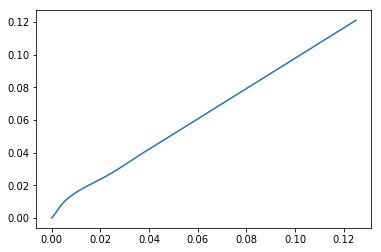

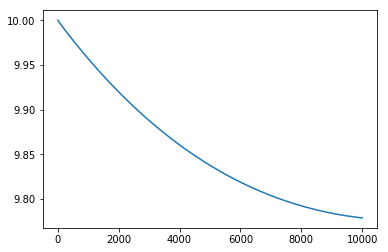

In [16]:
plt.figure()
plt.plot([p[0] for p in positions], [p[1] for p in positions])
plt.show()
#plt.figure()
#plt.plot([p[1] for p in positions])
#plt.show()
plt.figure()
plt.plot([p[2] for p in positions])
plt.show()

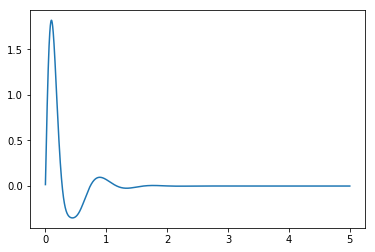

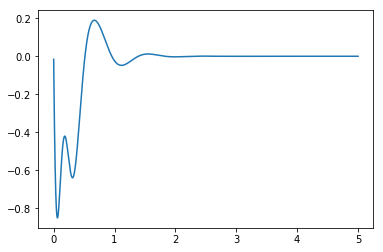

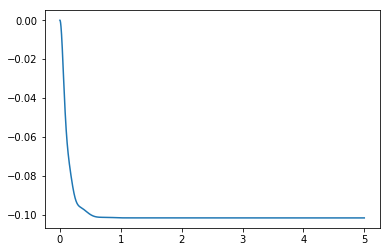

In [17]:
phis = []
thetas = []
psis = []
for q_cur in qs:
    phi, theta, psi = tait_bryan_from_quat(q_cur)
    phis.append(phi)
    thetas.append(theta)
    psis.append(psi)
    
plt.figure()
plt.plot(times, phis)
plt.show()

plt.figure()
plt.plot(times, thetas)
plt.show()

plt.figure()
plt.plot(times, psis)
plt.show()

In [18]:
def wtf(d):
    x_prev = np.array([0., 0., 0.,])
    v_prev = np.array([0., 0., 0.,])
    a_prev = np.array([0., 0., 0.,])

    poss = []
    
    dt = 0.0001
    for t in range(0, 50000):
        x_next = x_prev + v_prev*dt + 0.5*a_prev*dt*dt
        a_next = np.array([0., 0., -9.8]) - d*v_prev
        v_next = v_prev + 0.5*(a_next + a_prev)*dt
        
        x_prev = x_next
        a_prev = a_next
        v_prev = v_next
        
        poss.append(x_prev)
        
    plt.figure()
    plt.plot([p[2] for p in poss])
    plt.show()

In [19]:
#wtf(1.0)

In [20]:
#wtf(0.)

In [21]:
#phis

In [22]:
#thetas

In [23]:
tait_bryan_from_quat(q_init)

(0.0, 0.0, 0.0)

In [24]:
body_mass, body_inertia_tensor, arm_lengths = get_body_constants()
print(np.linalg.inv(body_inertia_tensor))
print(body_inertia_tensor)

[[18.93939394  0.          0.        ]
 [ 0.         18.93939394  0.        ]
 [ 0.          0.         10.04016064]]
[[0.0528 0.     0.    ]
 [0.     0.0528 0.    ]
 [0.     0.     0.0996]]
